# Предсказание риска сердечных приступов

В этом проекте предполагается работа с датасетом из открытого источника.Требуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке. 
В результате у вас должно получиться приложение на FastAPI (или аналогичном фреймворке) которое принимает на вход путь к csv файлу тестовой выборки, выполняет предсказание (например, путем POST запроса к сервису) и возвращает ответ в формате JSON. Допускается для тестирования написать скрипт, который посылает запрос к запущенному ранее приложению, либо реализовать веб-интерфейс.

<b>Задачи проекта</b> 

Предполагается, что в ходе работы над проектом будут решены следующие задачи:
●	Исследование датасета (предполагается поиск дополнительной информации для лучшего понимания природы данных)
●	Предобработка данных. 
●	Обучение модели
●	Подготовка предсказания на тестовой выборке. 
●	Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке
●	Написание инструмента для тестирования
●	Оформление документации

<b>Ход исследования</b>   

Данные пациентов для предсказания риска сердечных приступов
-	id  - id
-	Антропометрические параметры (вес, возраст, рост)
-	Привычки (курение, качество сна и т.д)
-	Давление
-	Наличие хронических заболеваний
-	Биохимия крови
-	Таргет - высокий или низкий риск поражения сердца


#### Загрузка и изучение данных

In [1]:
pip install scikit-learn==1.3.2 -q 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install shap -q 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install xgboost lightgbm catboost -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install statsmodels -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
from pathlib import Path  
import joblib
import shap
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_integer_dtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import  (
    fbeta_score, f1_score, precision_score, recall_score, roc_auc_score,
    average_precision_score
)
import shap

import warnings
warnings.filterwarnings('ignore')

In [7]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
TARGET_COL = "heart_attack_risk_binary"
K_BEST       = 15                    
SCORE_FUNC   = f_classif             
sns.set() 

In [8]:
heart_train = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/мастерская 1/data/raw/heart_train.csv', index_col='id')
heart_train.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,
2664,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302
9287,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767
5379,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930
8222,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442
4047,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860


In [9]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use        

`heart_train` состоит из 8685 записей и 27 столбцов, 243 пропуска в отдельных столбцах. Требуется доп обработка данных object.

In [10]:
heart_test = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/мастерская 1/data/raw/heart_test.csv', index_col='id')
heart_test.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,
7746,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093
4202,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860
6632,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070
4639,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814
4825,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349


In [11]:
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 7746 to 6521
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use         

`heart_test` состоит из 8685 записей и 26 столбцов, 31 пропуск в отдельных столбцах. Требуется доп обработка данных object.

In [12]:
heart_train['Unnamed: 0'].value_counts()

Unnamed: 0
0       1
5785    1
5799    1
5798    1
5797    1
       ..
2890    1
2889    1
2888    1
2887    1
8684    1
Name: count, Length: 8685, dtype: int64

In [13]:
heart_test['Unnamed: 0'].value_counts()

Unnamed: 0
0      1
604    1
636    1
637    1
638    1
      ..
326    1
327    1
328    1
329    1
965    1
Name: count, Length: 966, dtype: int64

Данный столбец использовался для нумерации строк в таблице, поэтому он нам не нужен.

In [14]:
heart_train = heart_train.drop('Unnamed: 0', axis=1)
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level          

In [15]:
heart_test = heart_test.drop('Unnamed: 0', axis=1)
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 7746 to 6521
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level           

#### Предобработка данных

Выполним предобработку данных. Изменим названия столбцов, типы данных, где это необходимо. Проведем проверку на явные и неявные дубликаты в данных.

##### Изменение наименования столбцов

Приведем наименования столбцов к змеиному регистру с помощью регулярных выражений.

In [16]:
def to_snake_case(name):
    name = name.strip()
    name = re.sub(r'[\s\-]+', '_', name)               # пробелы и дефисы → _
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name) # camelCase → camel_case
    name = re.sub(r'[^\w_]', '', name)                  # убрать лишние символы
    return name.lower()

heart_train.columns = [to_snake_case(c) for c in heart_train.columns]
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level          

In [17]:
heart_test.columns = [to_snake_case(c) for c in heart_test.columns]
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 7746 to 6521
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              966 non-null    float64
 1   cholesterol                      966 non-null    float64
 2   heart_rate                       966 non-null    float64
 3   diabetes                         935 non-null    float64
 4   family_history                   935 non-null    float64
 5   smoking                          935 non-null    float64
 6   obesity                          935 non-null    float64
 7   alcohol_consumption              935 non-null    float64
 8   exercise_hours_per_week          966 non-null    float64
 9   diet                             966 non-null    int64  
 10  previous_heart_problems          935 non-null    float64
 11  medication_use                   935 non-null    float64
 12  stress_level           

##### Обработка пропусков

In [18]:
heart_train[heart_train['stress_level'].isna()]

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,
9528,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814
9640,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209
9515,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558
9491,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163
9448,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9455,0.719101,0.49978,0.049496,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.138340,0.004034,0.003204,1.0,0.548387,0.558140
9506,0.651685,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.239130,0.055790,0.060783,1.0,0.729032,0.779070
9474,0.651685,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.276680,0.008673,0.150403,1.0,0.606452,0.790698


В обучающем наборе данных пропуски встречаются только в 9 конкретных признаках:          
`diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `physical_activity_days_per_week`, `previous_heart_problems`, `medication_use`, `stress_level`.

Все они связаны с образом жизни и историей болезни пациента.
Количество пропусков одинаковое во всех этих колонках — 243 записи (≈ 2,8% датасета). Это значит, что пропуски не случайны, а возникают «пакетом» для целых строк, что, вероятно, связано с особенностями сбора данных (например, неполные анкеты или пациенты, которым не задавали эти вопросы).                
Потеря 2,8% строк снизит размер обучающей выборки и может убрать целую подгруппу пациентов, что приведёт к смещению распределения признаков.

В тестовых данных возможны такие же паттерны пропусков, и если мы их выбросим из train, модель не научится корректно обрабатывать такие случаи.
Пропуски содержат потенциально полезную информацию — сам факт, что данные не заполнены, может коррелировать с вероятностью сердечного приступа (например, пациенты с неполной медицинской историей).

Стратегия обработки NaN:
- Сохранить все строки, включая те, где есть пропуски.
- Импутировать пропуски. Для бинарных признаков (0/1) — мода по обучающим данным. Для порядковых признаков (`stress_level`, `physical_activity_days_per_week`) — медиана. Для остальных числовых признаков — медиана.

Такой подход минимизирует потерю информации, сохраняет распределения признаков и при этом обеспечивает готовность данных для алгоритмов, которые не работают с NaN напрямую.

##### Обработка дубликатов

Перед построением модели прогнозирования риска сердечного приступа необходимо провести предварительную проверку качества исходных данных. Цель — выявить и устранить записи, которые могут исказить обучение модели: полные дубликаты строк, дубликаты с противоречивыми значениями целевого признака, а также неявные повторы.   
Это позволяет снизить риск переобучения, исключить влияние повторяющихся пациентов и повысить обобщающую способность модели.

Проверка на дубликаты выполняется в несколько этапов:
1. Полные дубликаты
- Ищем строки, полностью совпадающие по всем признакам (включая целевой признак).
- Если такие строки есть, оставляем только первую, остальные удаляем.
- Это исключает ситуации, когда один и тот же пациент учитывается несколько раз без изменений данных.

2. Дубликаты по признакам с разными значениями целевого признака (конфликтные записи)
- Определяем группы записей, полностью совпадающих по всем признакам, кроме целевого (`heart_attack_risk_binary`).
- Если внутри группы встречаются разные значения целевого признака, удаляем все такие записи.
- Это предотвращает попадание в обучающую выборку противоречивой информации, которая мешает алгоритму обучаться.

3. Дубликаты по признакам с одинаковым целевым признаком (неявные дубликаты)
- Если записи совпадают по всем признакам и целевому признаку, но различаются по индексу (ID), оставляем только первую.
- Это снижает искусственное увеличение веса отдельных примеров в обучении.

In [19]:
def drop_duplicates_and_conflicts(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    """
    Удаляет полные и конфликтные дубликаты и печатает статистику.
    """
    df = df.copy()

    # 1) Полные дубликаты
    full_dupes = df.duplicated(keep="first")
    n_full_dupes = full_dupes.sum()
    df = df[~full_dupes]

    # 2) Конфликтные дубликаты (одинаковые фичи, разный таргет)
    feature_cols = [c for c in df.columns if c != target_col]
    grp = df.groupby(feature_cols, dropna=False)[target_col].nunique()
    conflict_keys = grp[grp > 1].index
    n_conflict_groups = len(conflict_keys)

    if n_conflict_groups > 0:
        conflict_df = pd.DataFrame(list(conflict_keys), columns=feature_cols)
        df = df.merge(conflict_df.assign(__conflict__=1), how="left", on=feature_cols)
        df = df[df["__conflict__"].isna()].drop(columns="__conflict__")

    # 3) Неявные дубликаты (одинаковые фичи + одинаковый таргет)
    feature_cols = [c for c in df.columns if c != target_col]
    same_dupes = df.duplicated(subset=feature_cols + [target_col], keep="first")
    n_same_dupes = same_dupes.sum()
    df = df[~same_dupes]

    # --- Вывод результатов ---
    print("Результат проверки для текущих данных")
    print(f"Полные дубликаты: {n_full_dupes} записей.")
    print(f"Дубликаты по признакам с разными целевыми значениями: {n_conflict_groups} групп.")
    print(f"Неявные дубликаты (одинаковые признаки + одинаковый целевой): {n_same_dupes} записей.")

    return df

In [20]:
heart_train = drop_duplicates_and_conflicts(heart_train, 'heart_attack_risk_binary')

Результат проверки для текущих данных
Полные дубликаты: 0 записей.
Дубликаты по признакам с разными целевыми значениями: 0 групп.
Неявные дубликаты (одинаковые признаки + одинаковый целевой): 0 записей.


Таким образом, в данных нет явных или скрытых дубликатов, которые требовали бы удаления, однако проверка включена в предобработку для предотвращения подобных проблем при поступлении новых данных.

##### Нормализация столбца gender

In [21]:
heart_train['gender'].value_counts()

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

In [22]:
heart_test['gender'].value_counts()

gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64

В исходных данных признак `gender` представлен в смешанном формате: часть записей — строковые значения (Male/Female), часть — числовые (0, 1, 0.0, 1.0). Такой разнородный тип данных может вызвать ошибки или некорректное поведение при автоматической обработке в пайплайне.
Поэтому принято решение закодировать `gender` вручную в числовой бинарный формат (1 — мужчина, 0 — женщина) до подачи данных в модель.

In [23]:
def normalize_gender(series: pd.Series) -> pd.Series:
    """
    male/female, '1'/'0', '1.0'/'0.0' -> {1.0, 0.0}, NaN сохраняем
    """
    s = series.astype(str).str.strip().str.lower()
    s = (s.replace({"male":"1","female":"0"})
           .str.replace(".0","", regex=False)
           .replace({"nan": np.nan}))
    return pd.to_numeric(s, errors="coerce")

In [24]:
if "gender" in heart_train.columns:
    heart_train["gender"] = normalize_gender(heart_train["gender"])
if "gender" in heart_test.columns:
    heart_test["gender"] = normalize_gender(heart_test["gender"])

In [25]:
heart_train['gender'].value_counts()

gender
1    6038
0    2647
Name: count, dtype: int64

In [26]:
heart_test['gender'].value_counts()

gender
1    672
0    294
Name: count, dtype: int64

Таким образом, `gender` был преобразован в единый числовой флаг, что делает обработку данных более надёжной и предсказуемой для всех типов моделей, включая алгоритмы деревьев и линейные классификаторы.

##### Изменение типа данных

Для бинарных, категориальных и порядковых признаков надёжнее переводить значения в int перед кодированием — это исключает неоднозначную интерпретацию и проблемы с обработкой, а так же уберет визуальный шум при построении графиков.

In [27]:
int_features = [
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'previous_heart_problems',
    'medication_use',
    'gender',
    
    # Порядковые признаки
    'diet',
    'stress_level',
    'physical_activity_days_per_week'
]

# Приведение к int
for col in int_features:
    heart_train[col] = heart_train[col].dropna().astype(int)
    heart_test[col] = heart_test[col].dropna().astype(int)

In [28]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int32  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level          

Большинство столбцов, требующих перевод в int, содержат NaN, поэтому смена типа лданных будет реализована после обработки NaN в пайплайне.

#### Исследовательский анализ данных

#####  Статистический анализ числовых признаков

In [29]:
heart_train.describe()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
count,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,...,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,...,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.695222,0.450295,0.497634
std,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,...,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.460340,0.170184,0.171830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,...,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.000000,0.303226,0.348837
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,...,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,1.000000,0.445161,0.500000
75%,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,...,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,1.000000,0.600000,0.651163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,...,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Большинство признаков — числовые (float), но значения в диапазоне [0,1] встречаются очень часто, что говорит о масштабировании (min-max normalization) или кодировании как доли.
Есть признаки, где значения — целые числа в небольших диапазонах.

1. Признаки, вероятно, масштабированные в [0,1]
- Почти все «медицинские» метрики имеют: min = 0, max = 1, Средние ≈ 0.45–0.50, std ~0.28
- Это сильно похоже на min-max scaling до диапазона [0,1]. Примеры: `age`, `cholesterol`, `triglycerides`, `blood_sugar`, `ck_mb`, `troponin`.

2. Бинарные признаки (0/1)
- `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `gender`
- Минимум = 0, максимум = 1, среднее в диапазоне 0.48–0.90 (разный баланс классов).
- Вероятно, изначально были категориальные ответы («Да/Нет») → закодированы в 0/1.

3. Порядковые признаки
- `physical_activity_days_per_week`: min=0, max=7, медиана=3 → это кол-во активных дней в неделю.
- `stress_level`: min=1, max=10, равномерное распределение по шкале.

4. Целевой признак
- `heart_attack_risk_binary`: баланс сильно смещён — среднее 0.3469 → ~34,7% положительных случаев.
- Это несбалансированный датасет → при моделировании придётся учитывать (class_weight, oversampling/undersampling, metrics focus).

Выводы:
- Бинарные признаки — не масштабировать, просто импутировать модой.
- Порядковые признаки — импутировать медианой.
- Масштабированные признаки — оставить как есть, чтобы не «перемасштабировать».
- Несбалансированность таргета — использовать метрики чувствительные к дисбалансу (ROC-AUC, PR-AUC, Recall) и балансировку классов в моделях.

In [30]:
heart_test.describe()

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
count,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,...,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,...,0.476796,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,0.695652,0.447172,0.496822
std,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,...,0.291987,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,0.460369,0.171837,0.173935
min,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,...,0.002598,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.000000,0.012903,0.116279
25%,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,...,0.217527,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,0.000000,0.296774,0.348837
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,...,0.471185,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,1.000000,0.445161,0.488372
75%,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,...,0.720503,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,1.000000,0.600000,0.639535
max,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,...,0.999496,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,1.000000,0.741935,0.790698


В тестовом наборе картинка почти та же, что и в train, что хорошо для обучения.

Перед началом анализа признаков мы отдельно рассматриваем распределение целевого признака heart_attack_risk_binary. Этот шаг необходим, чтобы оценить баланс классов в выборке и понять, требуется ли в дальнейшем применение методов коррекции дисбаланса (например, использование параметра class_weight, oversampling или undersampling).

В нашем случае целевой признак бинарный:
- 0 — отсутствие риска сердечного приступа,
- 1 — наличие риска.

Анализ распределения позволит заранее определить долю каждого класса и выбрать подходящие метрики для оценки модели. При сильной несбалансированности классов особое внимание будет уделено метрикам, чувствительным к дисбалансу.

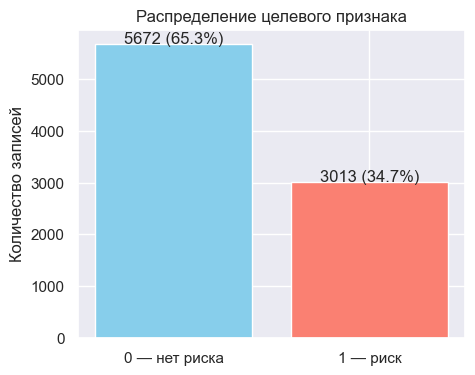

heart_attack_risk_binary
0.0    5672
1.0    3013
Name: count, dtype: int64
heart_attack_risk_binary
0.0    65.31
1.0    34.69
Name: count, dtype: float64


In [31]:
target_counts = heart_train["heart_attack_risk_binary"].value_counts().sort_index()
target_perc = target_counts / target_counts.sum() * 100

plt.figure(figsize=(5,4))
plt.bar(target_counts.index.astype(str), target_counts.values, color=["skyblue","salmon"])
plt.xticks([0,1], ["0 — нет риска", "1 — риск"])
plt.ylabel("Количество записей")
plt.title("Распределение целевого признака")

for idx, val in enumerate(target_counts.values):
    plt.text(idx, val + 10, f"{val} ({target_perc.iloc[idx]:.1f}%)", ha="center")

plt.show()

print(target_counts)
print(target_perc.round(2))

После изучения распределения целевого признака переходим к анализу всех входных признаков в обучающем наборе данных. Цель этого этапа — выявить особенности распределений, определить тип каждого признака (бинарный, дискретный, порядковый или непрерывный), а также зафиксировать потенциальные аномалии или выбросы.

Для каждого числового признака строятся:
- Диаграмма распределения (гистограмма для непрерывных признаков или столбчатая диаграмма для дискретных/бинарных);
- Боксплот для визуального обнаружения выбросов и оценки диапазона значений.

Этот анализ помогает:
- Определить признаки, требующие особой предобработки (масштабирование, кодирование, удаление выбросов);
- Проверить согласованность данных в train и test;
- Найти признаки, которые уже нормированы или закодированы, чтобы избежать лишней обработки в пайплайне.

Особое внимание уделяется бинарным и порядковым признакам, так как для них используются отдельные стратегии импутации и обработки.

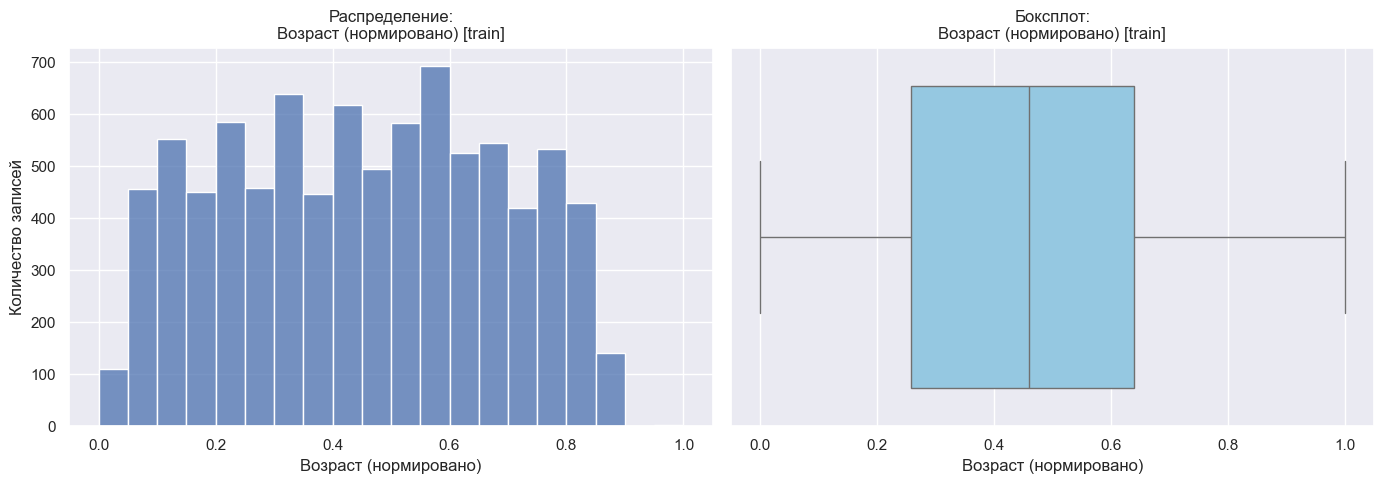

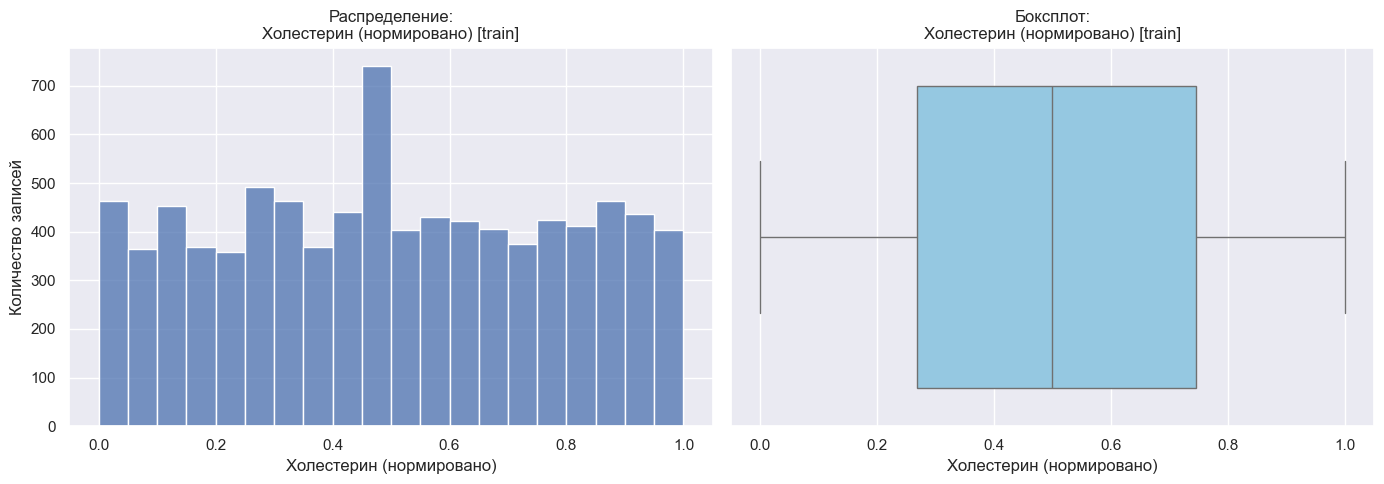

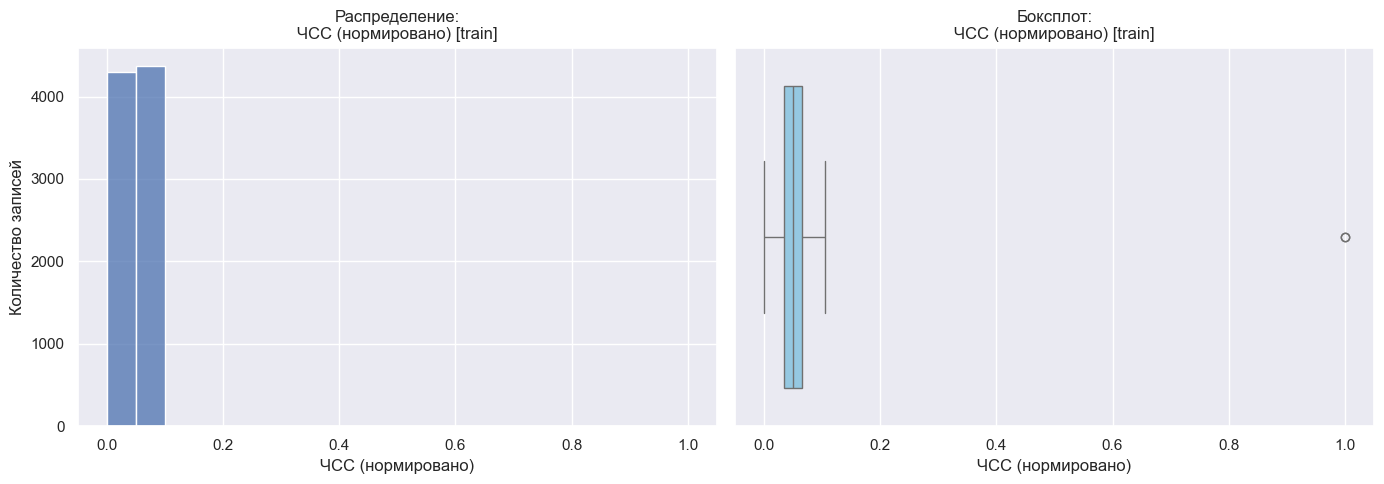

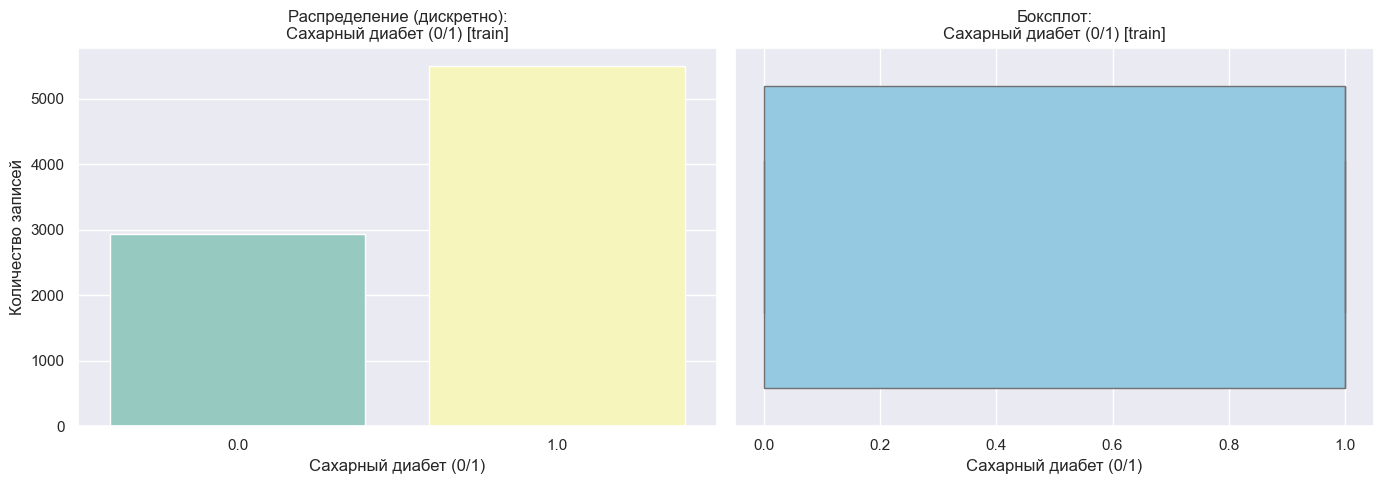

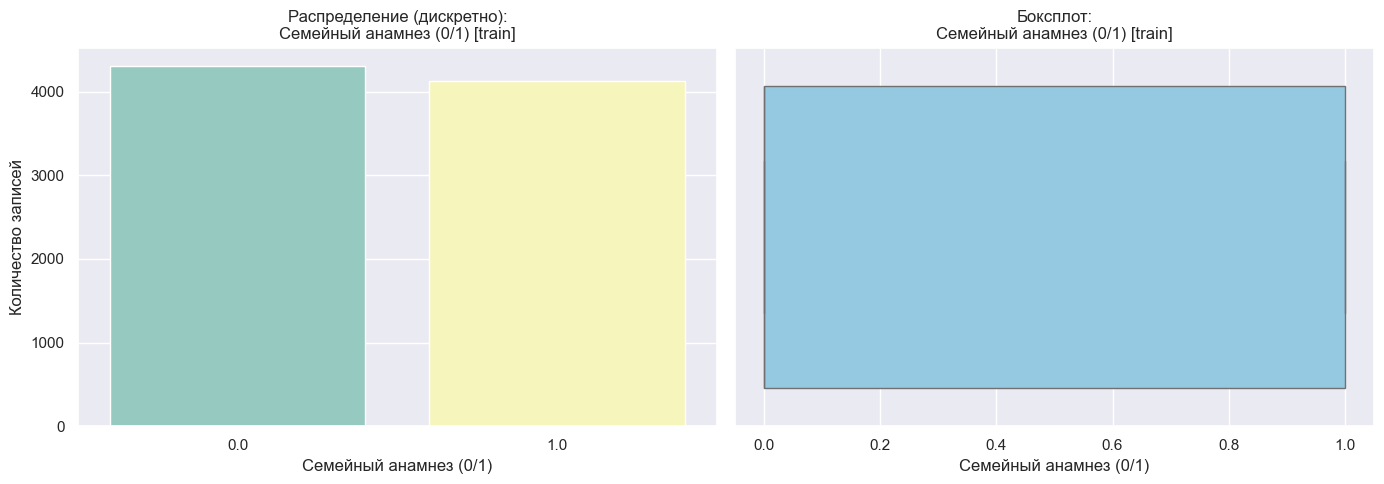

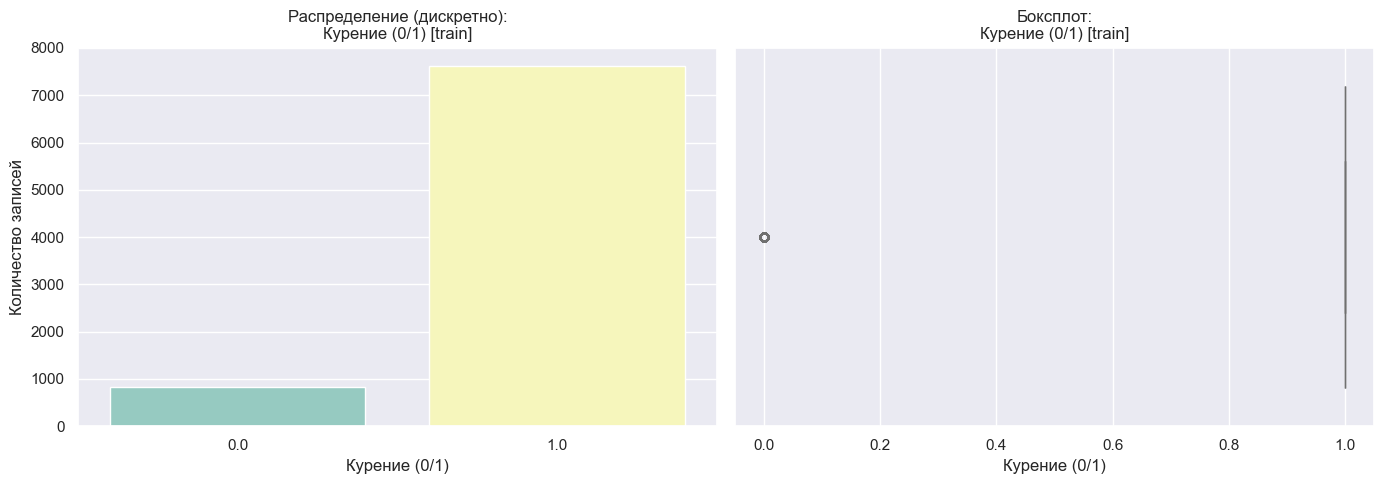

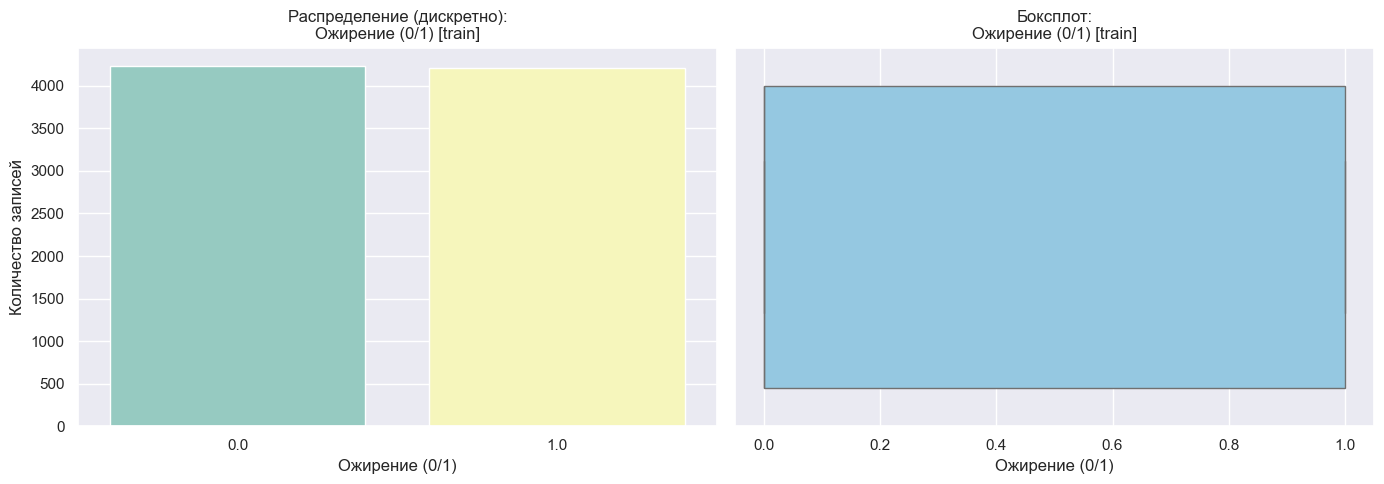

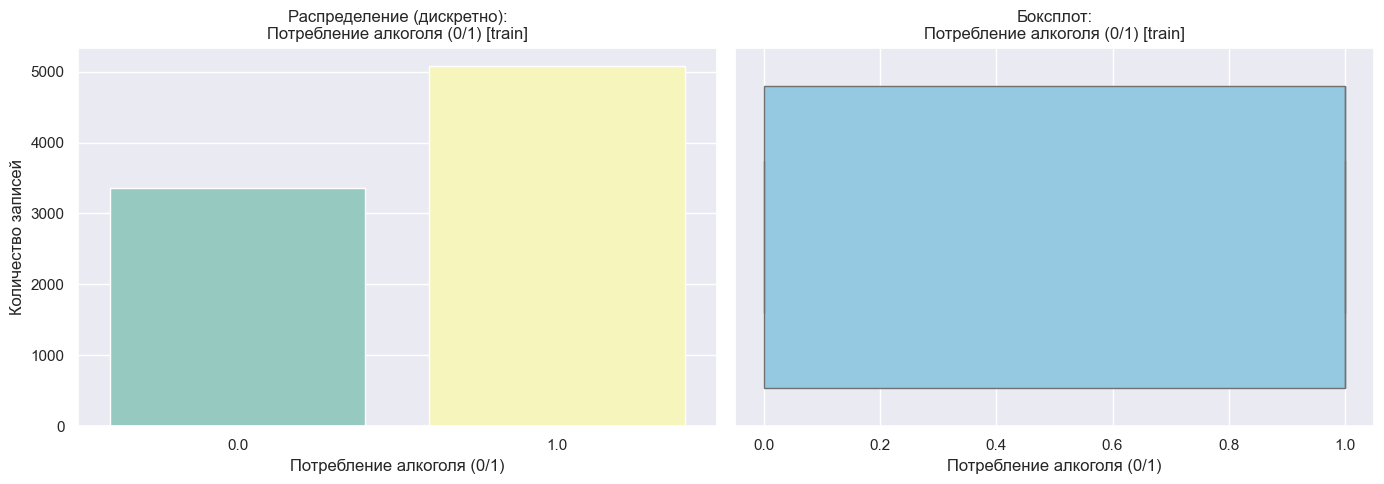

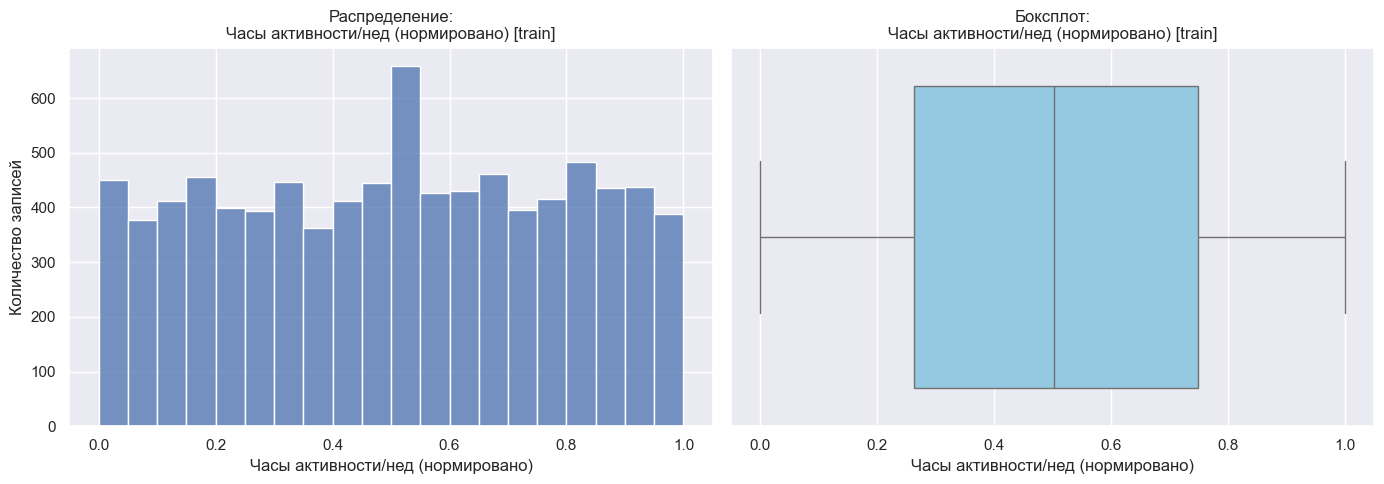

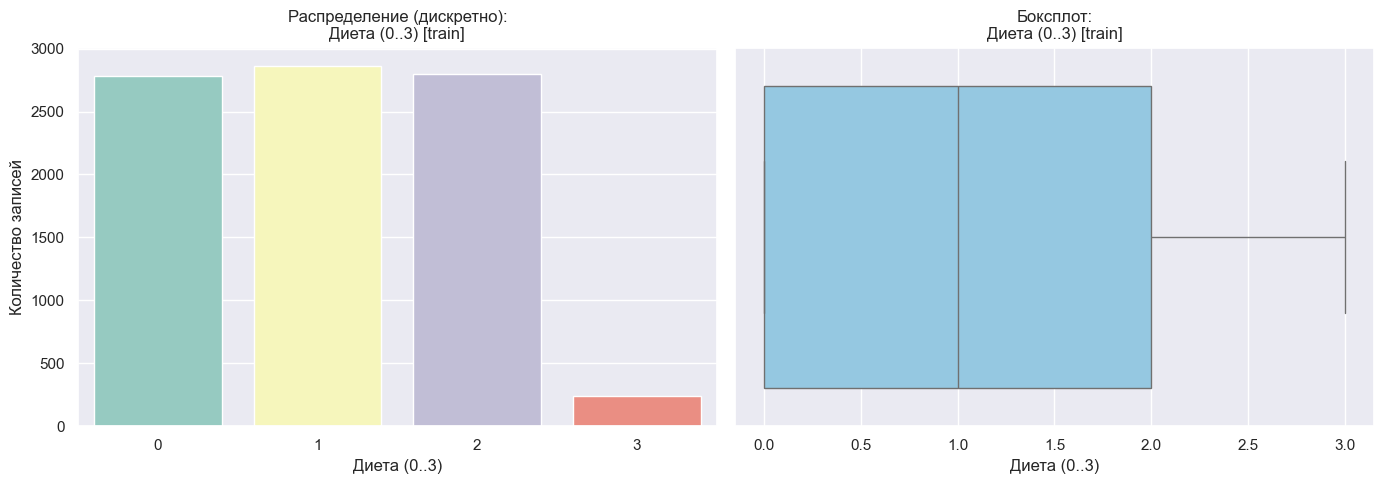

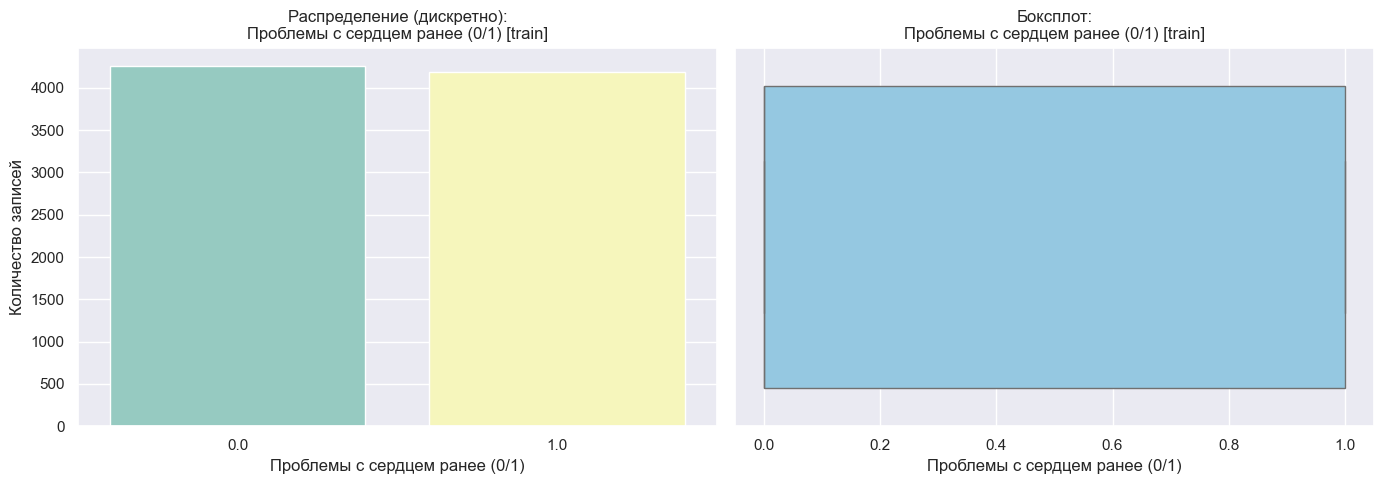

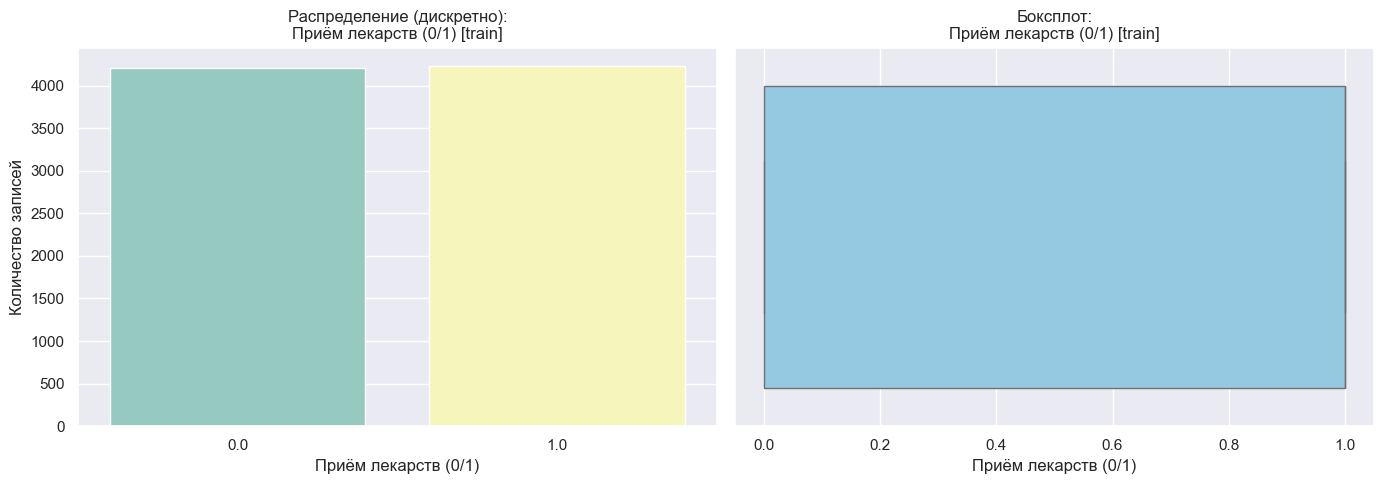

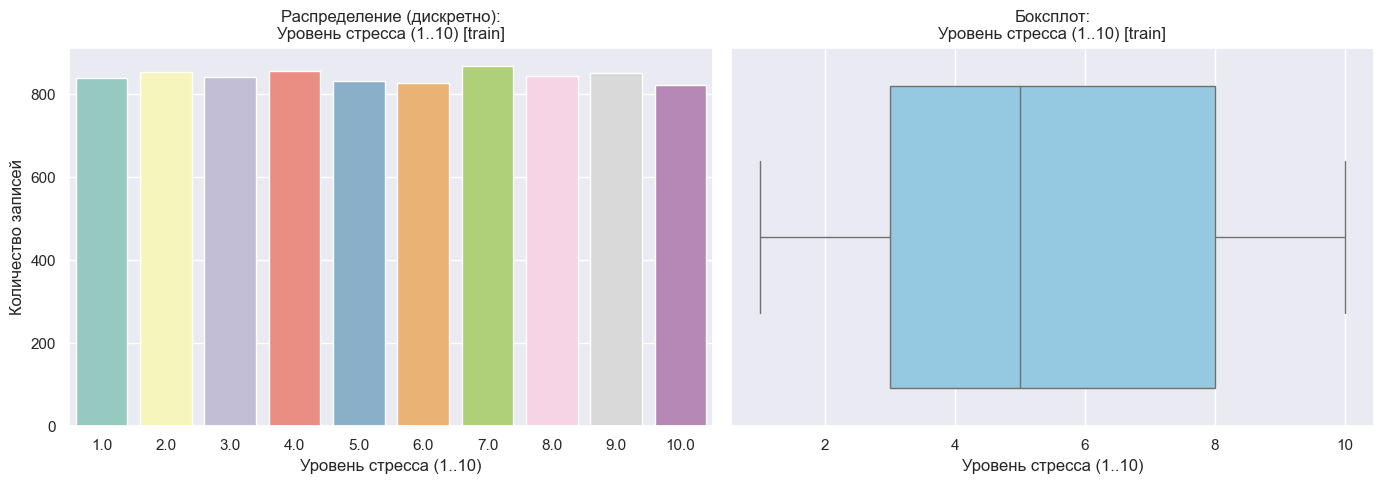

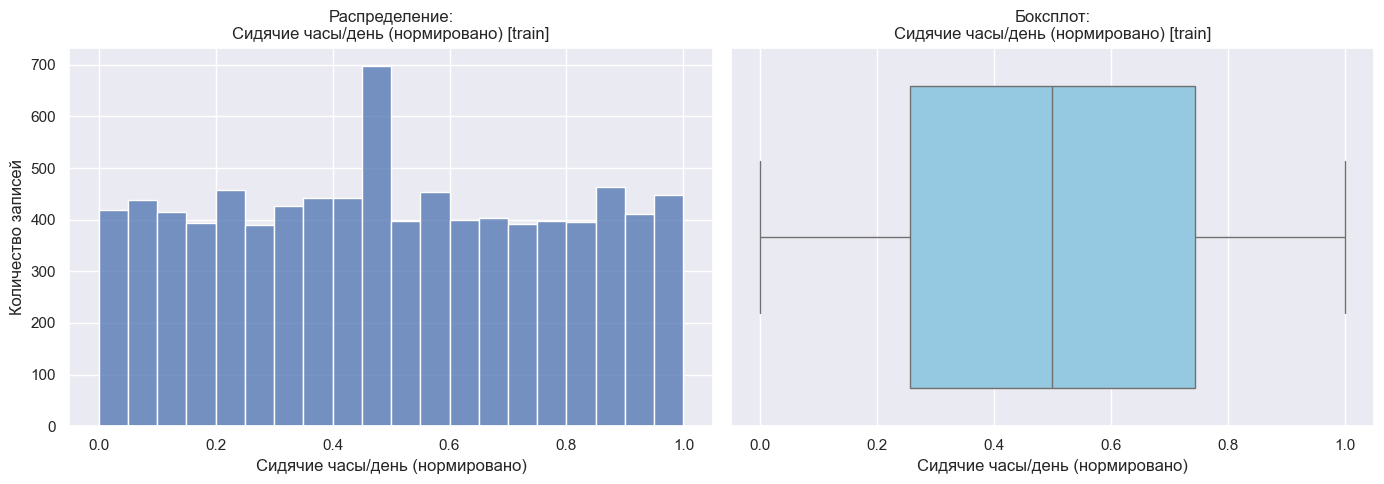

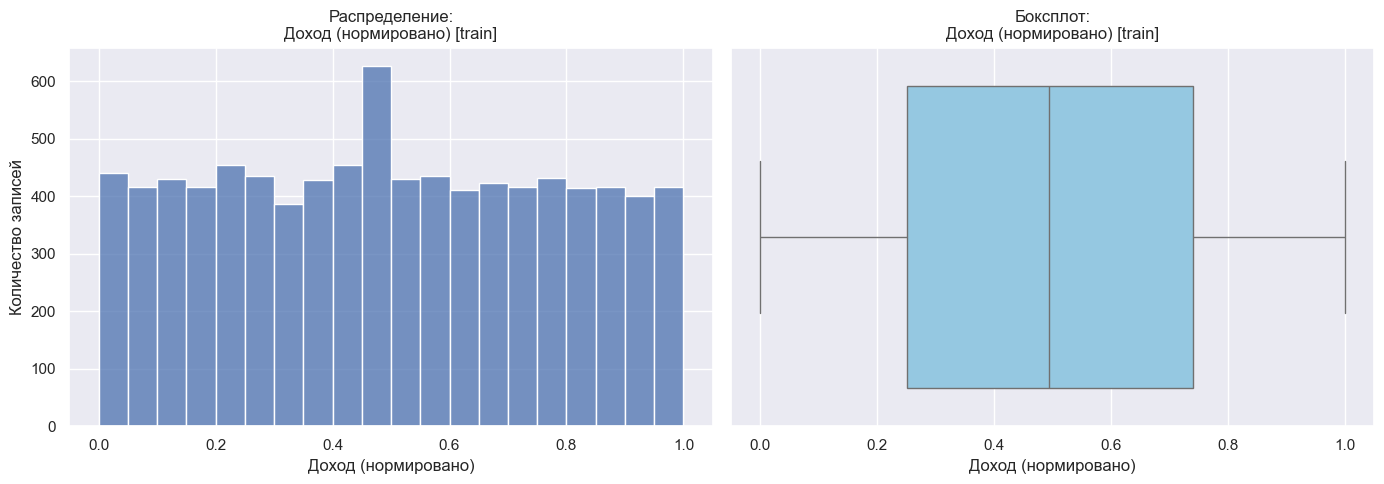

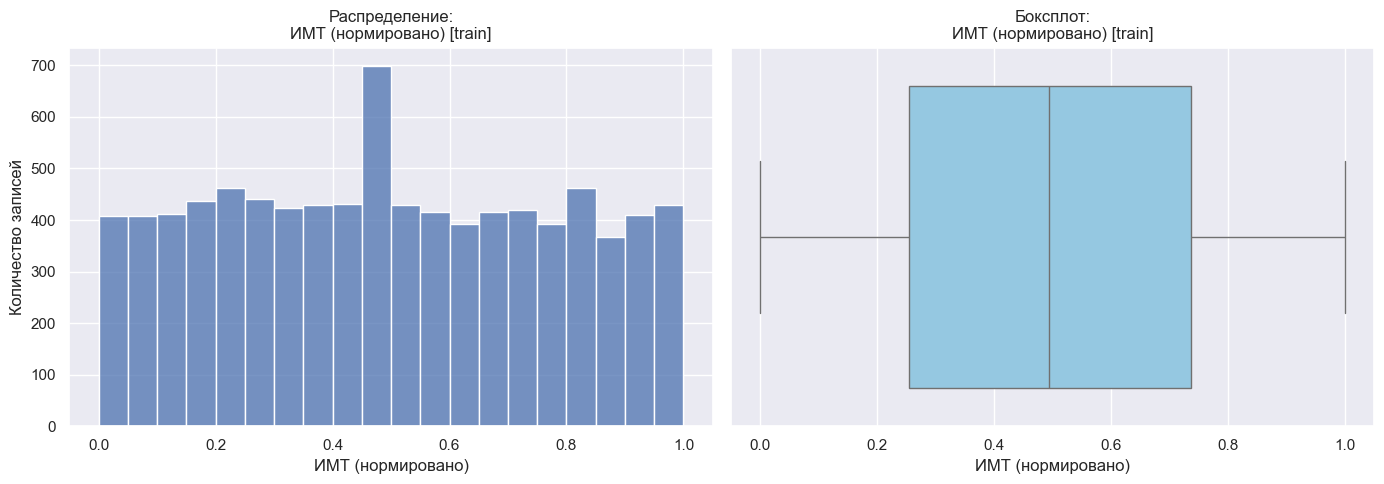

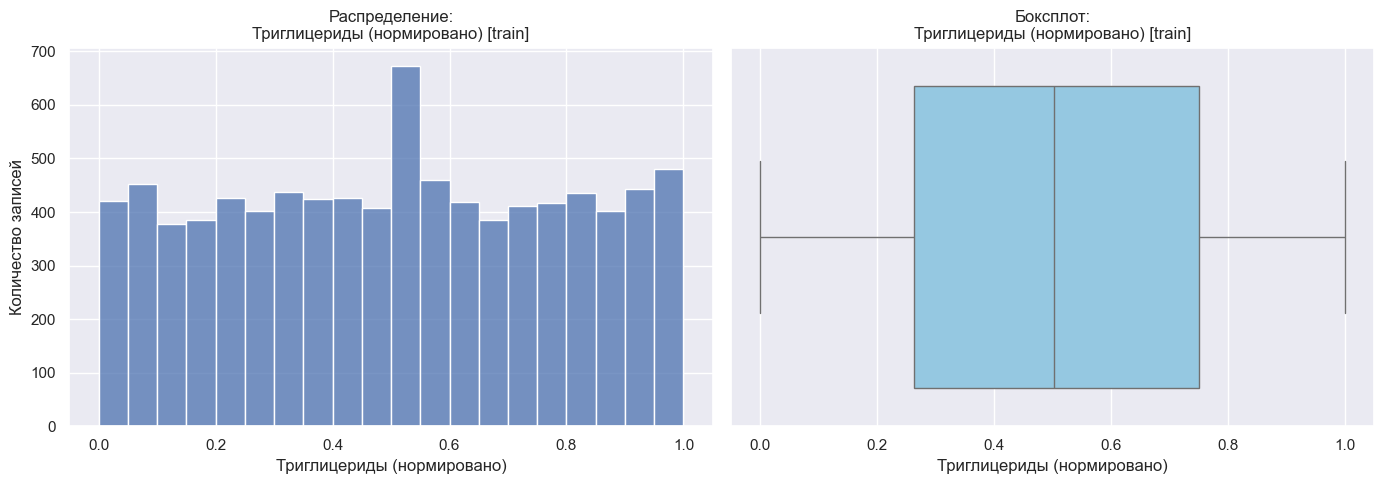

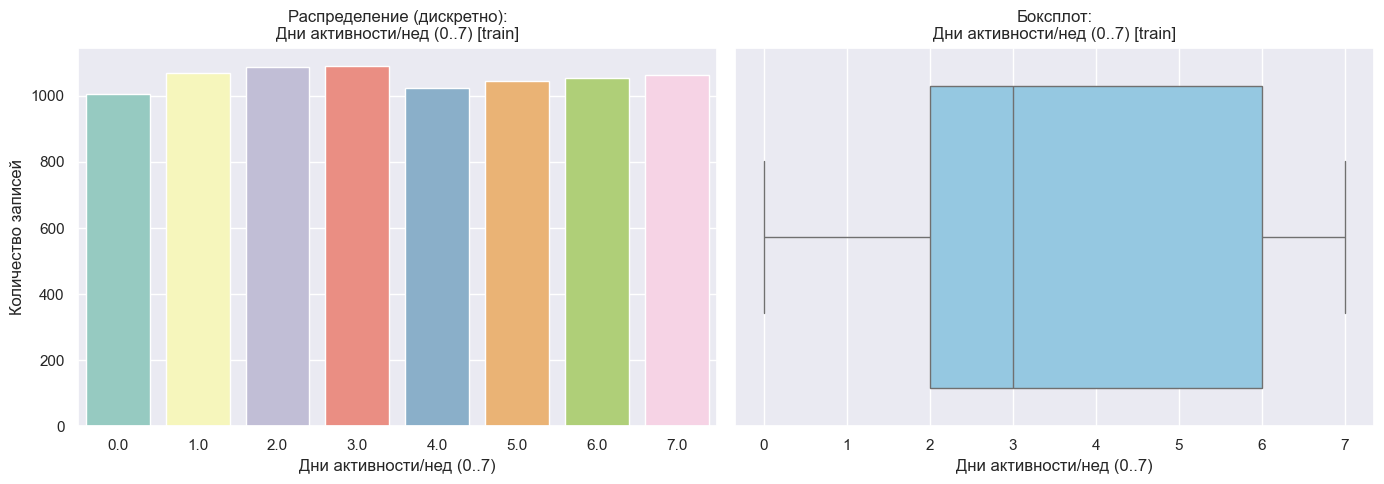

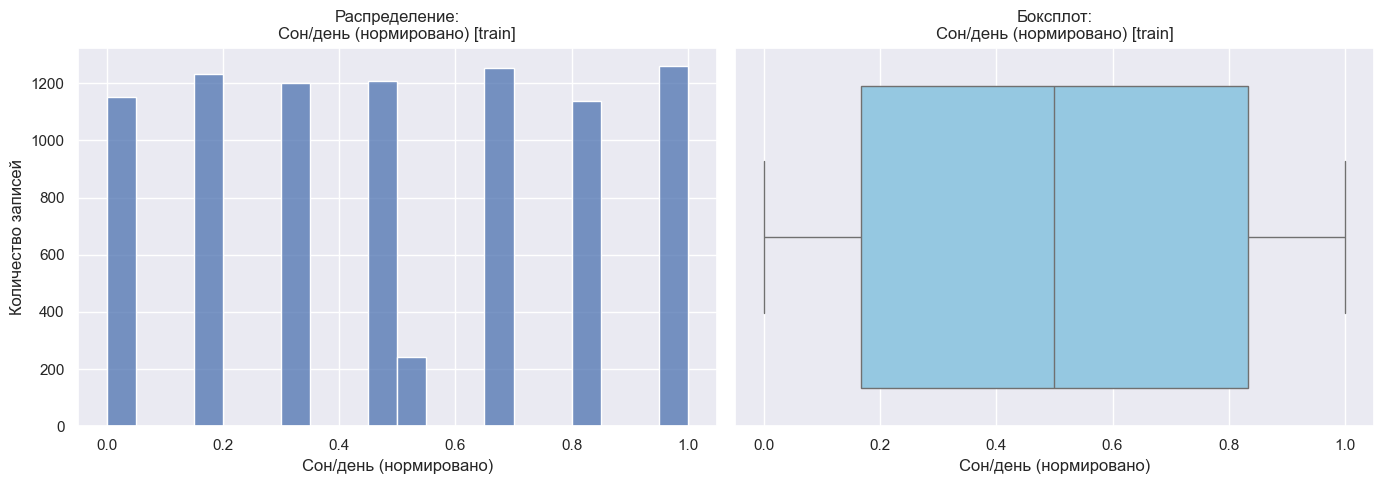

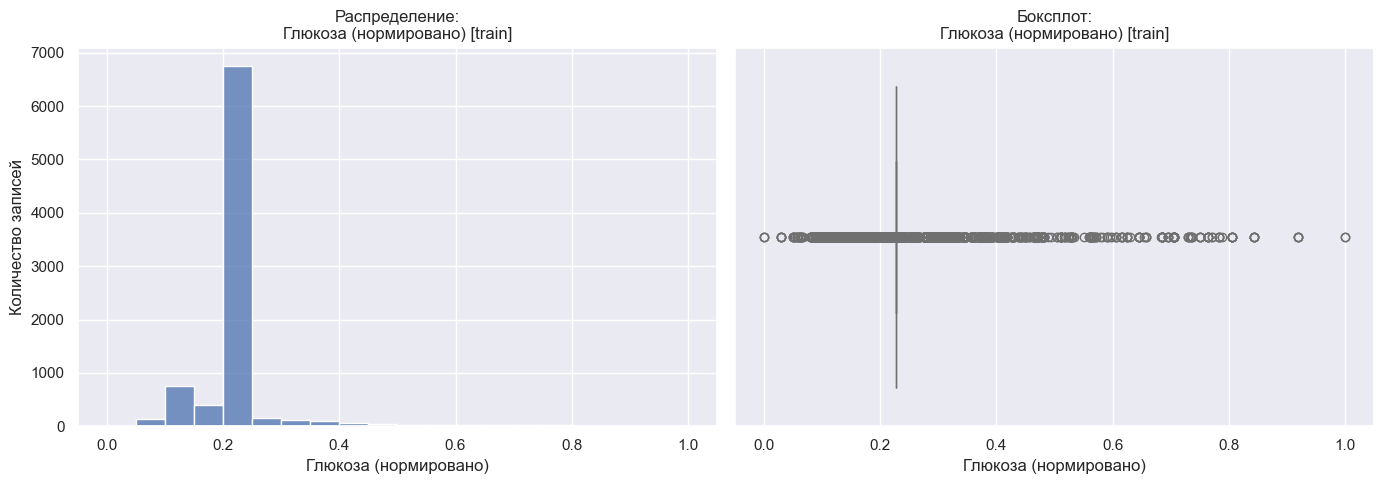

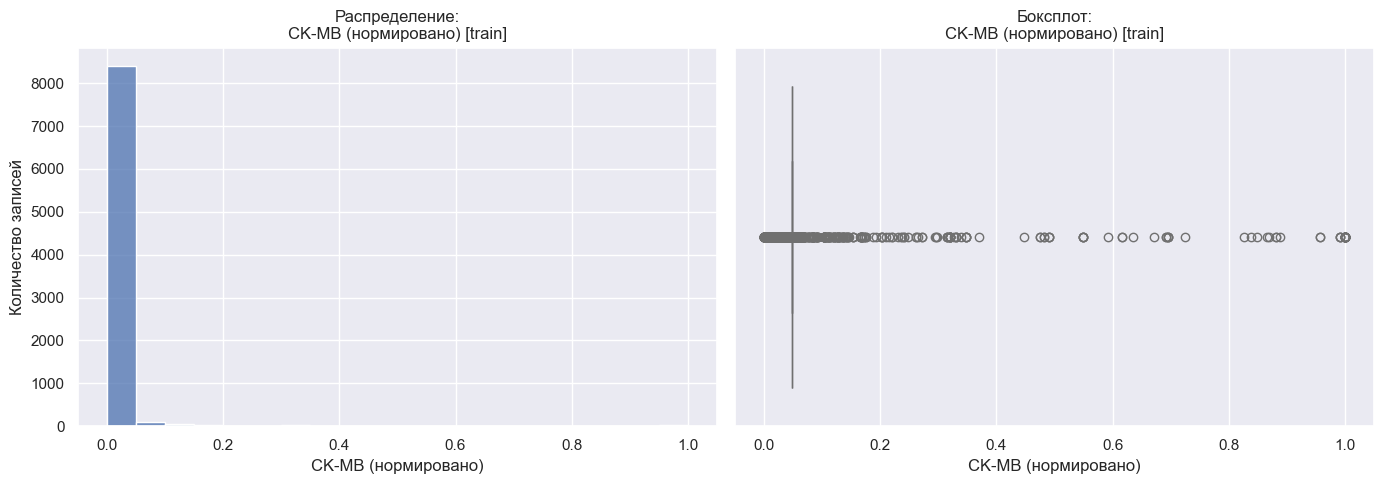

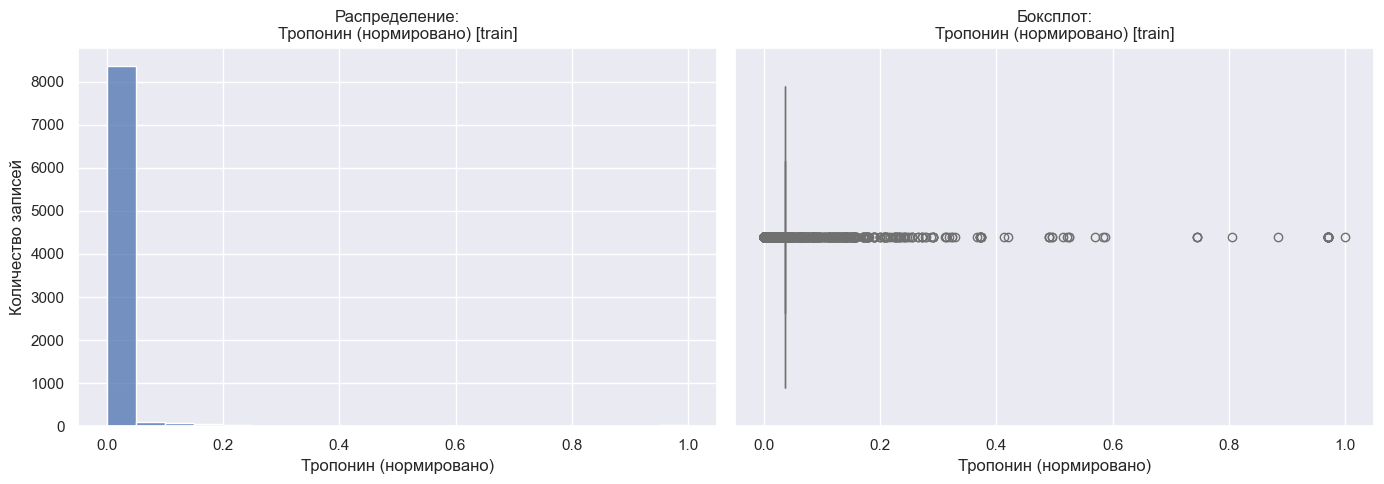

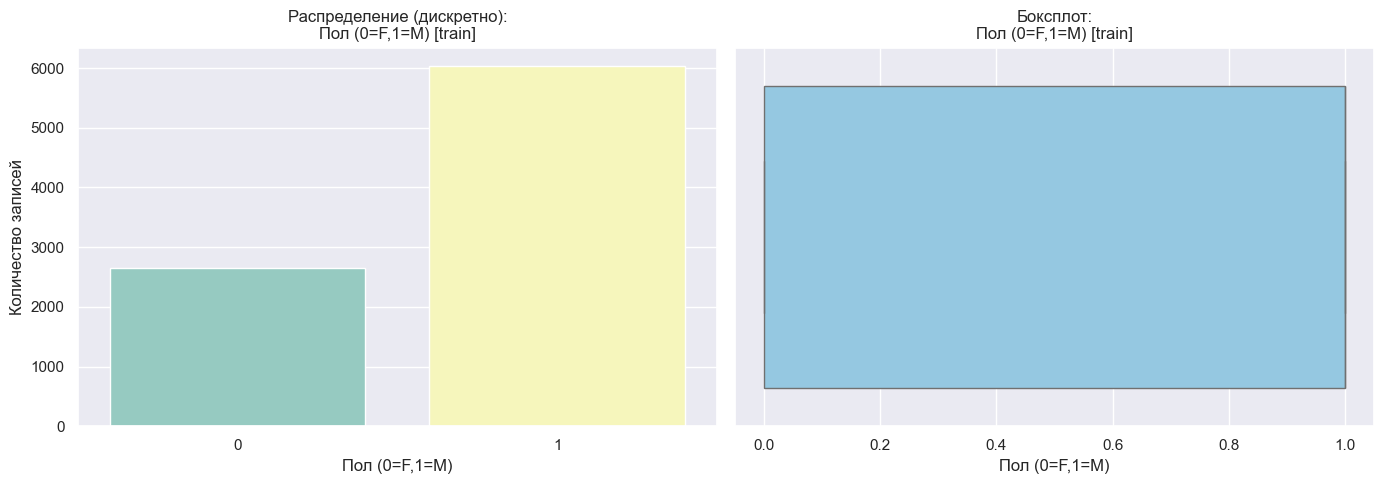

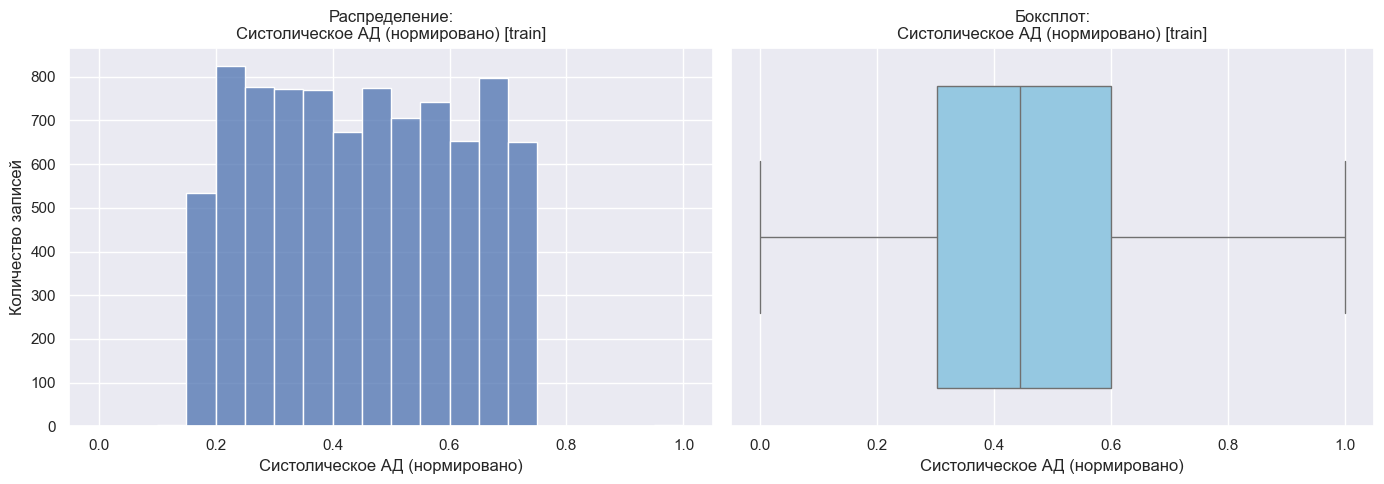

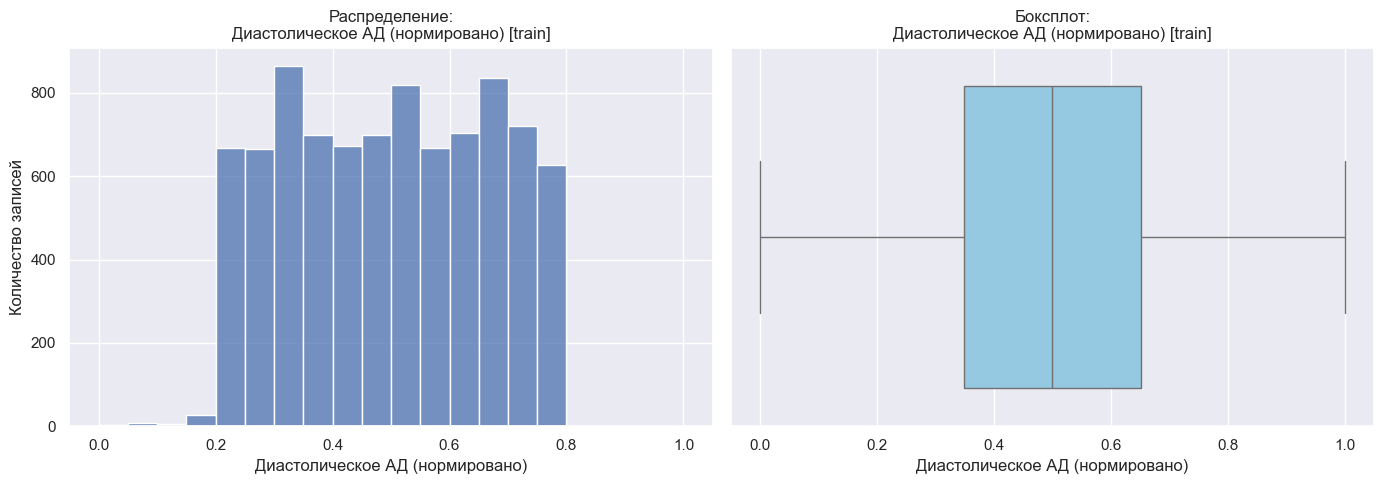

In [33]:
TARGET_COL = "heart_attack_risk_binary"

def is_binary_feature(s: pd.Series) -> bool:
    vals = set(pd.to_numeric(s.dropna(), errors="coerce").unique().tolist())
    return len(vals) <= 2 and vals.issubset({0, 1})

def is_discrete_feature(s: pd.Series, threshold: int = 15) -> bool:
    if is_binary_feature(s):
        return True
    nunique_ok = s.nunique(dropna=True) < threshold
    if is_integer_dtype(s):
        return nunique_ok
    s_num = pd.to_numeric(s.dropna(), errors="coerce")
    all_int_like = (s_num == np.floor(s_num)).all()
    return nunique_ok and bool(all_int_like)

axis_labels = {
    "age": "Возраст (нормировано)",
    "cholesterol": "Холестерин (нормировано)",
    "heart_rate": "ЧСС (нормировано)",
    "diabetes": "Сахарный диабет (0/1)",
    "family_history": "Семейный анамнез (0/1)",
    "smoking": "Курение (0/1)",
    "obesity": "Ожирение (0/1)",
    "alcohol_consumption": "Потребление алкоголя (0/1)",
    "exercise_hours_per_week": "Часы активности/нед (нормировано)",
    "diet": "Диета (0..3)",
    "previous_heart_problems": "Проблемы с сердцем ранее (0/1)",
    "medication_use": "Приём лекарств (0/1)",
    "stress_level": "Уровень стресса (1..10)",
    "sedentary_hours_per_day": "Сидячие часы/день (нормировано)",
    "income": "Доход (нормировано)",
    "bmi": "ИМТ (нормировано)",
    "triglycerides": "Триглицериды (нормировано)",
    "physical_activity_days_per_week": "Дни активности/нед (0..7)",
    "sleep_hours_per_day": "Сон/день (нормировано)",
    "blood_sugar": "Глюкоза (нормировано)",
    "ck_mb": "CK-MB (нормировано)",
    "troponin": "Тропонин (нормировано)",
    "gender": "Пол (0=F,1=M)",
    "systolic_blood_pressure": "Систолическое АД (нормировано)",
    "diastolic_blood_pressure": "Диастолическое АД (нормировано)",
}

def palette_for_k(k: int):
    if k <= 12:
        return sns.color_palette("Set3", k)
    elif k <= 20:
        return sns.color_palette("tab20", k)
    else:
        return sns.color_palette("husl", k)

def plot_feature_distributions(df: pd.DataFrame, dataset_name: str = "train", with_hue: bool = False):
    num_cols = df.select_dtypes(include="number").columns.tolist()
    num_cols = [c for c in num_cols if c.lower() not in ("id",)]
    if TARGET_COL in num_cols:
        num_cols.remove(TARGET_COL)

    for col in num_cols:
        s = df[col]
        label = axis_labels.get(col, col)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        if is_discrete_feature(s, threshold=15):
            cats = sorted(s.dropna().unique().tolist())
            pal = palette_for_k(len(cats))

            if with_hue and TARGET_COL in df.columns:                
                sns.countplot(
                    data=df, x=col, hue=TARGET_COL,
                    order=cats, palette="Set2", ax=axes[0]
                )
                axes[0].legend(title="target", loc="best")
            else:
                sns.countplot(
                    data=df, x=col,
                    order=cats, palette=pal, ax=axes[0]
                )

            axes[0].set_title(f"Распределение (дискретно):\n{label} [{dataset_name}]")
            axes[0].set_xlabel(label)
            axes[0].set_ylabel("Количество записей")
        else:
            sns.histplot(s.dropna(), bins=20, kde=False, ax=axes[0], color="#4C72B0")
            axes[0].set_title(f"Распределение:\n{label} [{dataset_name}]")
            axes[0].set_xlabel(label)
            axes[0].set_ylabel("Количество записей")

        sns.boxplot(x=s, ax=axes[1], color="#88CCEE")
        axes[1].set_title(f"Боксплот:\n{label} [{dataset_name}]")
        axes[1].set_xlabel(label)

        plt.tight_layout()
        plt.show()

plot_feature_distributions(heart_train, dataset_name="train", with_hue=False)


1. Бинарные признаки
Примеры: `gender`, `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption` и др.

Распределение:
`gender` — доля мужчин значительно выше (~72%), что создаёт дисбаланс.
У некоторых других бинарных фичей (например, smoking) также наблюдается перекос в сторону одного класса.
Пропуски: Визуально на countplot не видны, но ранее зафиксированы групповые NaN в одних и тех же записях.

2. Порядковые признаки
Примеры: `stress_level`, `diet`, `physical_activity_days_per_week`.

Распределение:
`physical_activity_days_per_week` — заметен пик на нуле (полное отсутствие активности).
`diet` — редкие высокие значения (3), которые могут быть как выбросами, так и признаком малой подгруппы.

3. Непрерывные признаки
Примеры: `age`, `cholesterol`, `heart_rate`, `bmi`, `triglycerides`, `systolic_bp`, `diastolic_bp`, `glucose`, `ck_mb`, `troponin`.

Распределения:
`age`— смещение в сторону старших пациентов.
`systolic_bp` и `diastolic_bp` — равномерные распределения, выбросов почти нет.
`cholesterol` — умеренно симметричен, редкие выбросы.
`glucose` — скошен вправо, есть значимые выбросы в верхнем диапазоне.
`ck_mb` и `troponin` — очень сильный правый перекос, множество выбросов, >95% значений близки к нулю.

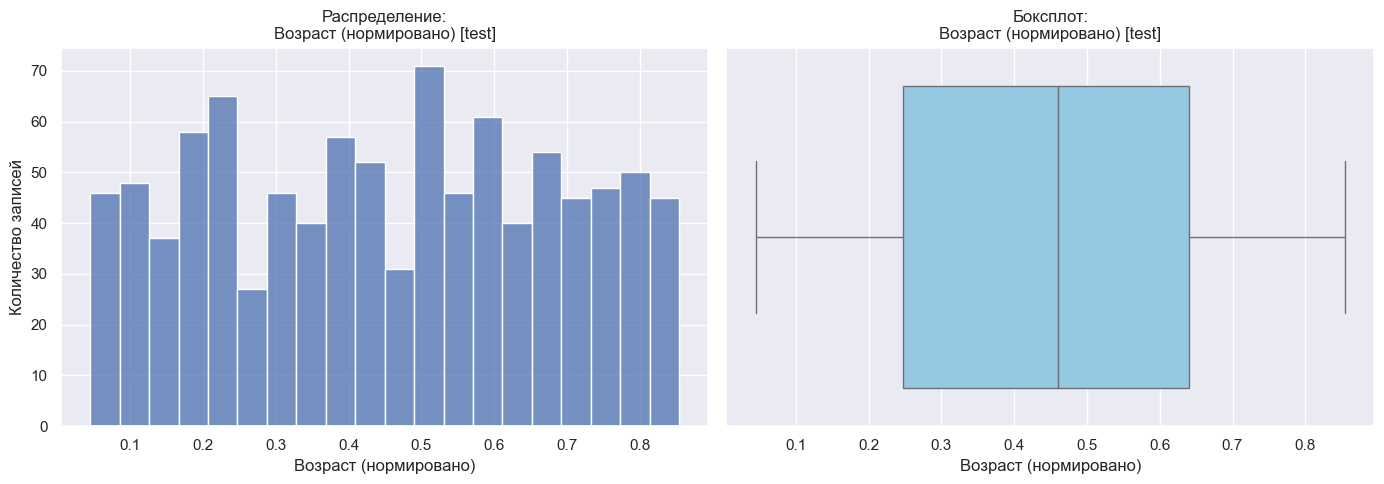

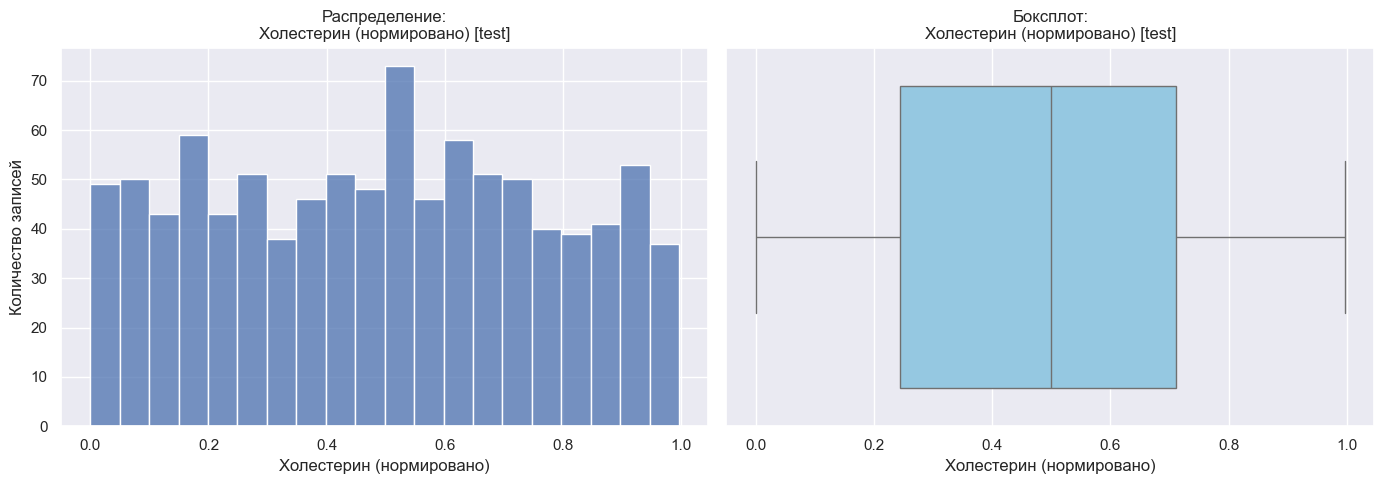

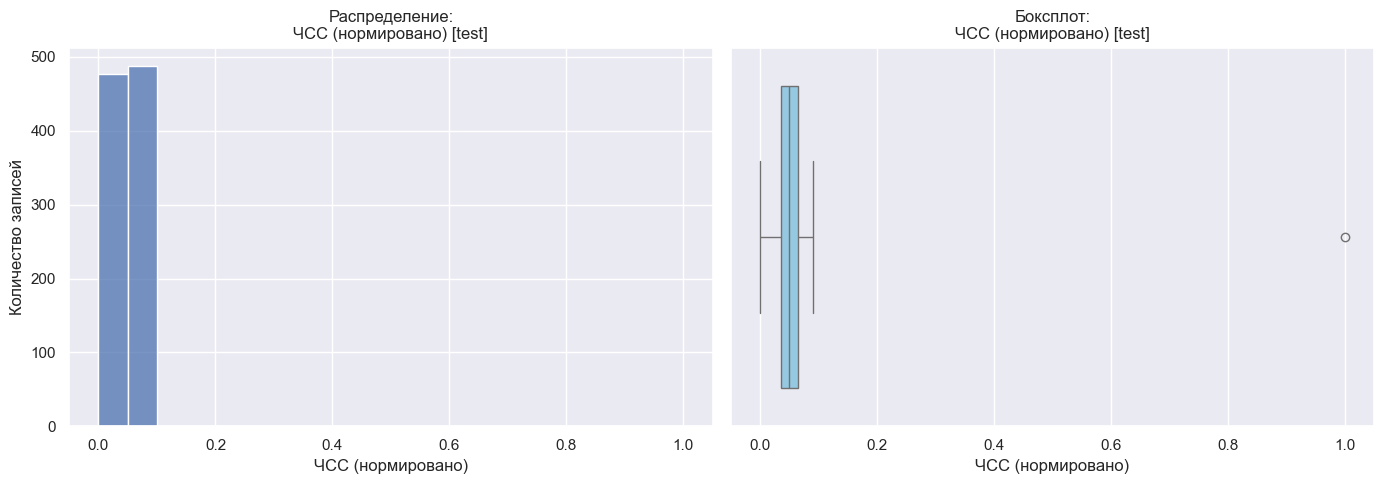

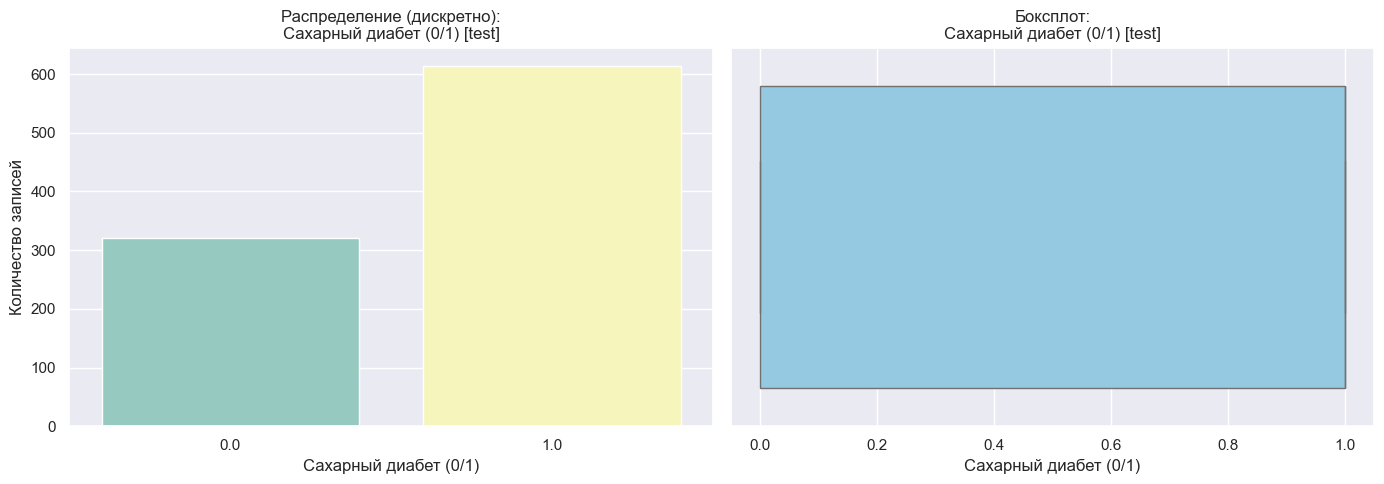

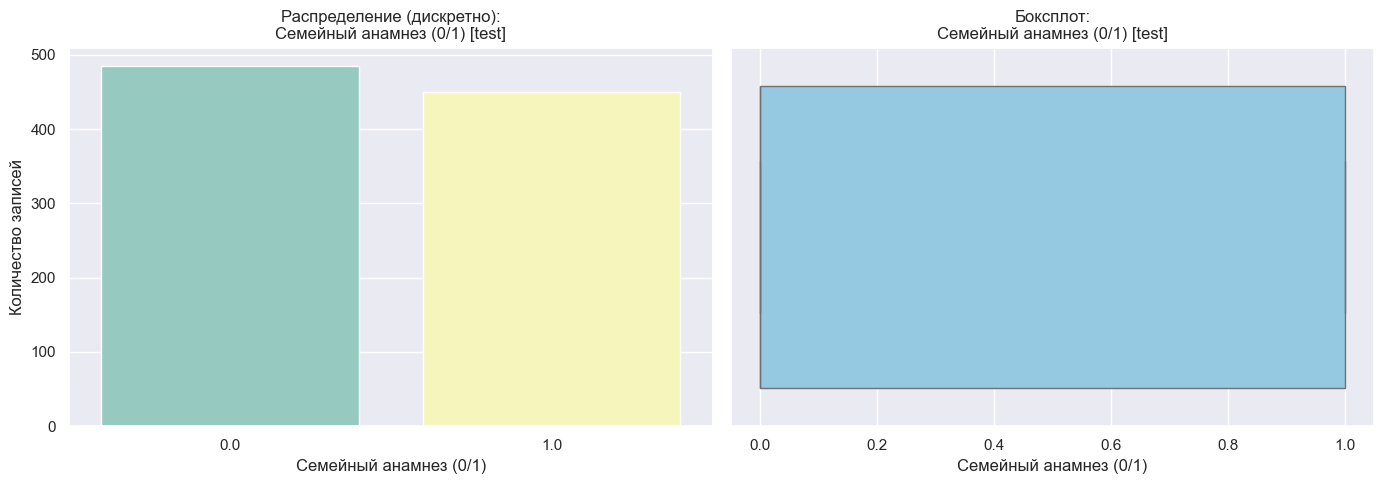

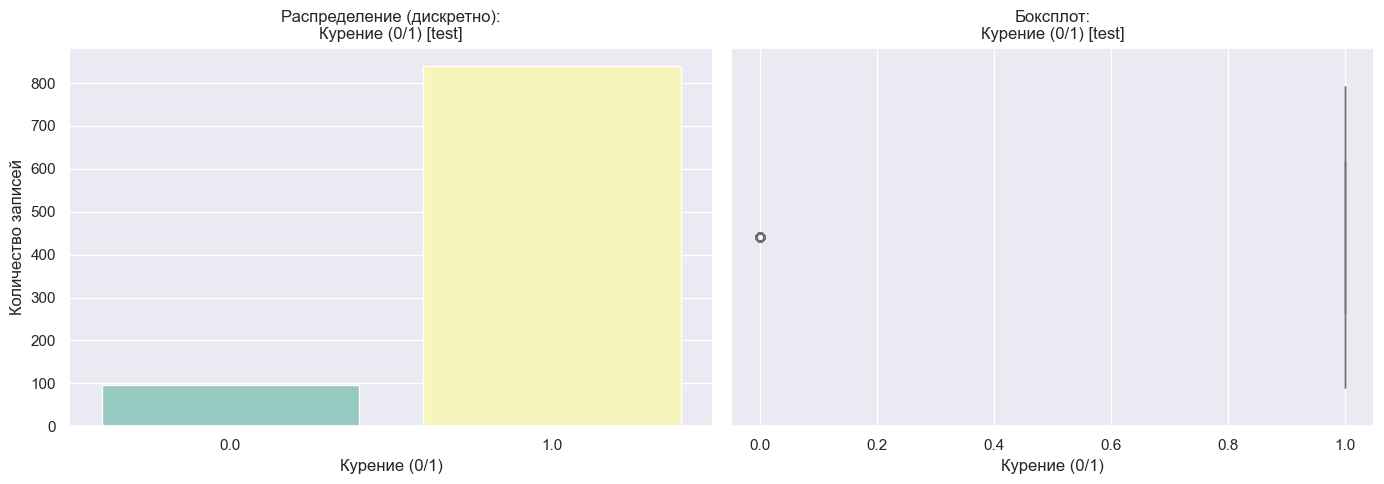

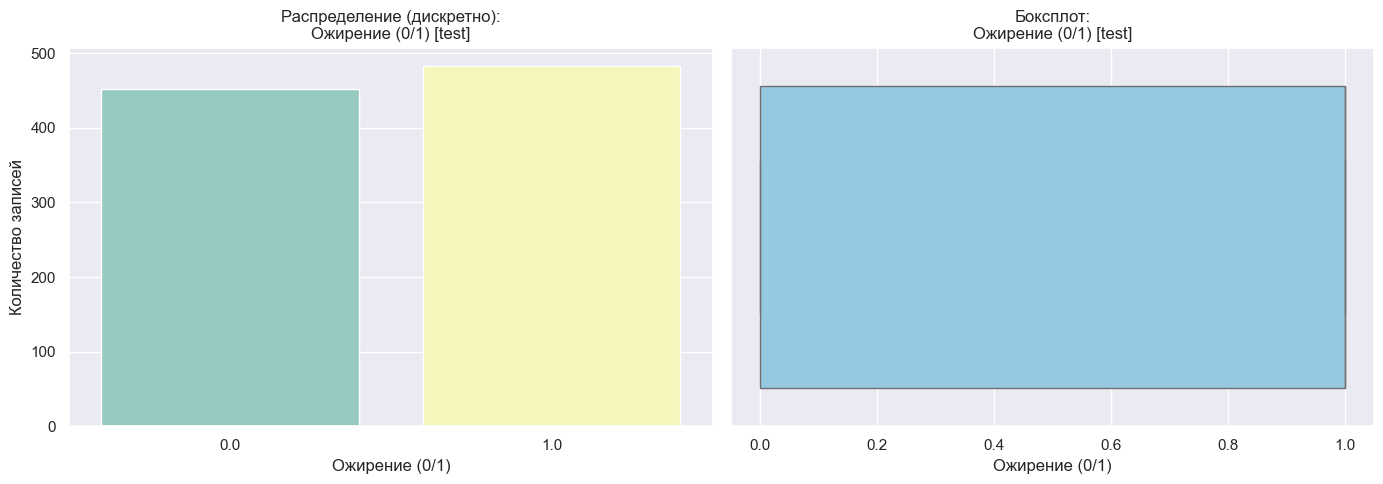

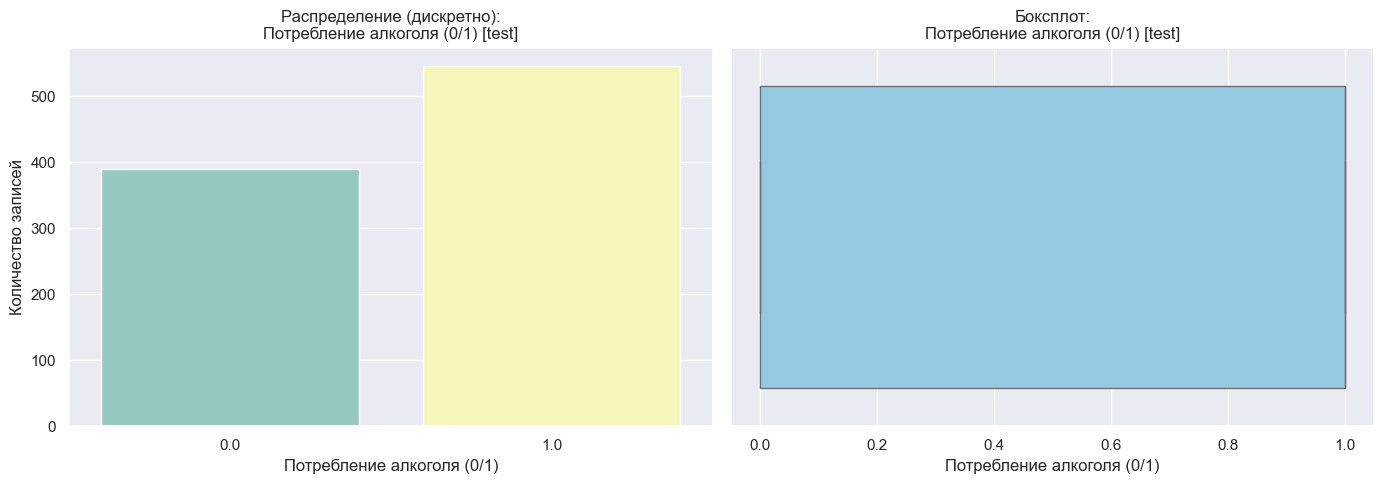

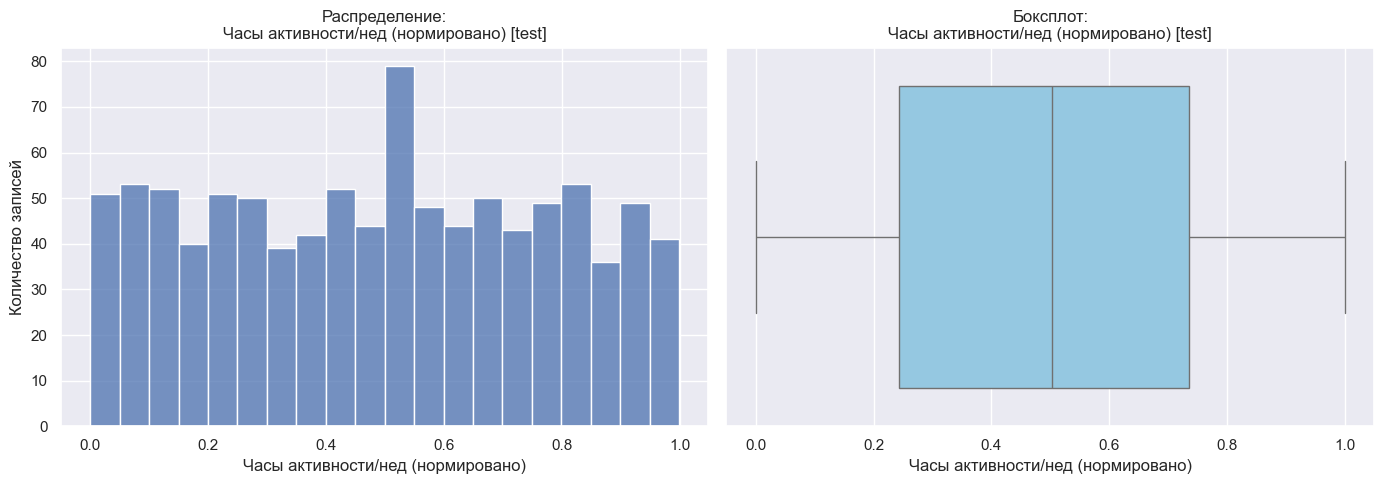

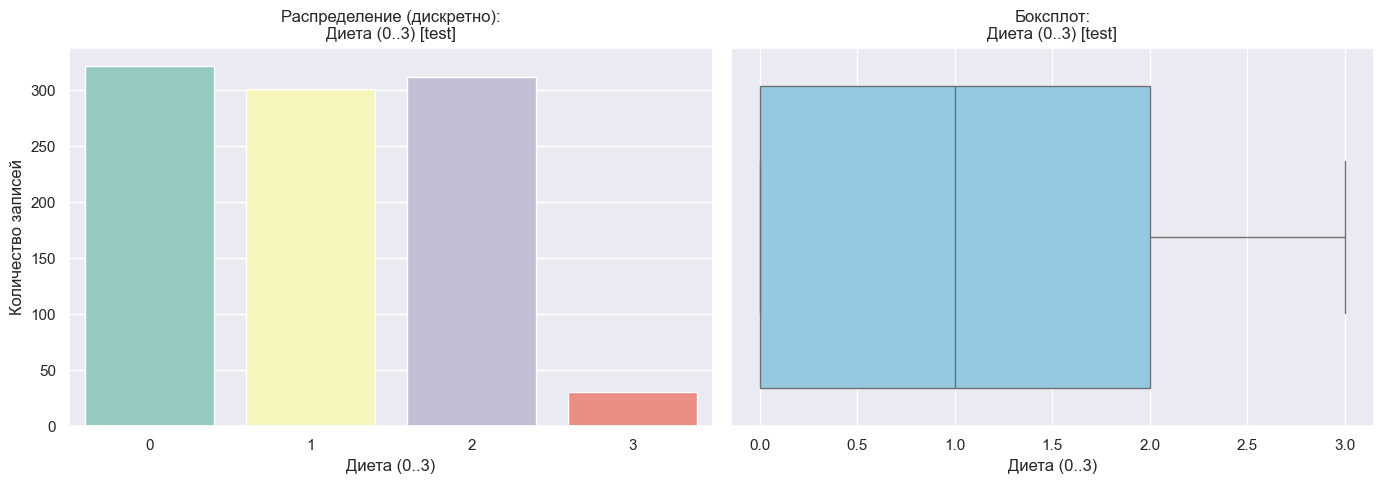

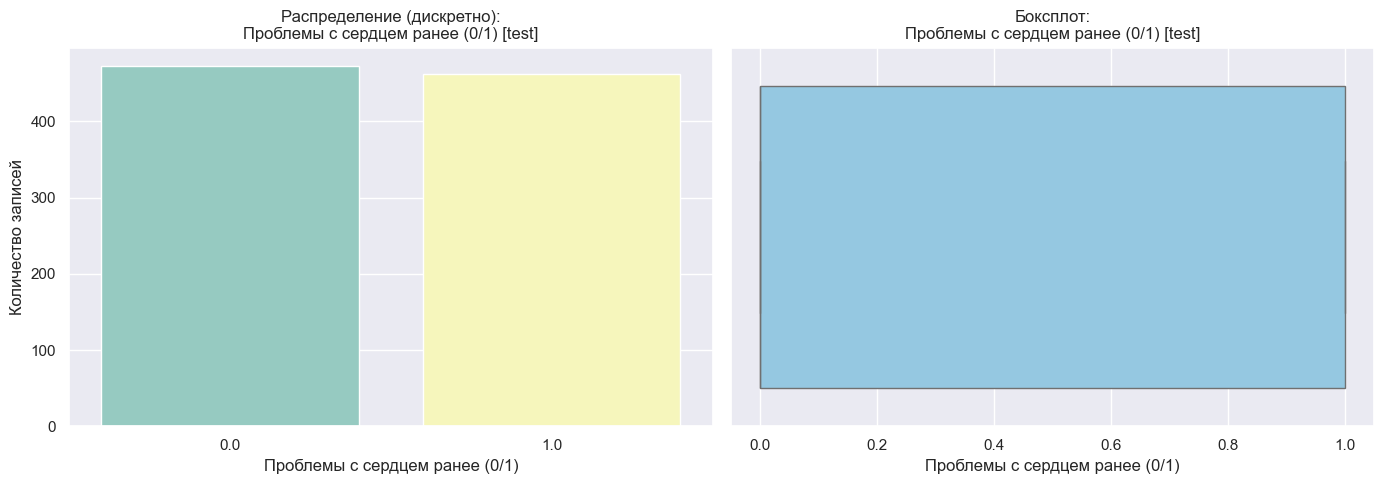

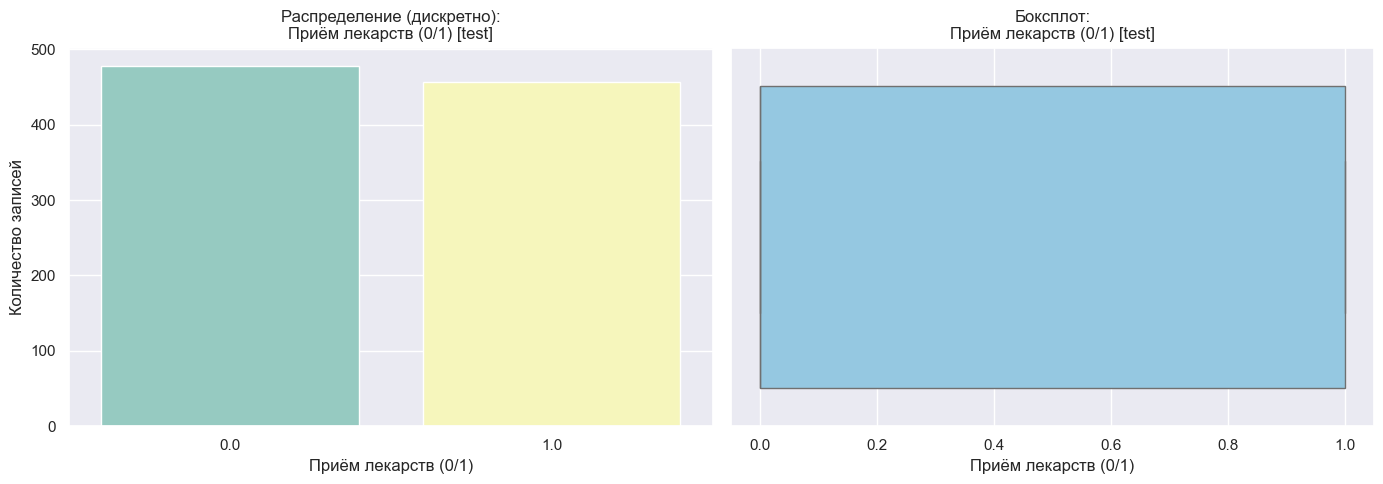

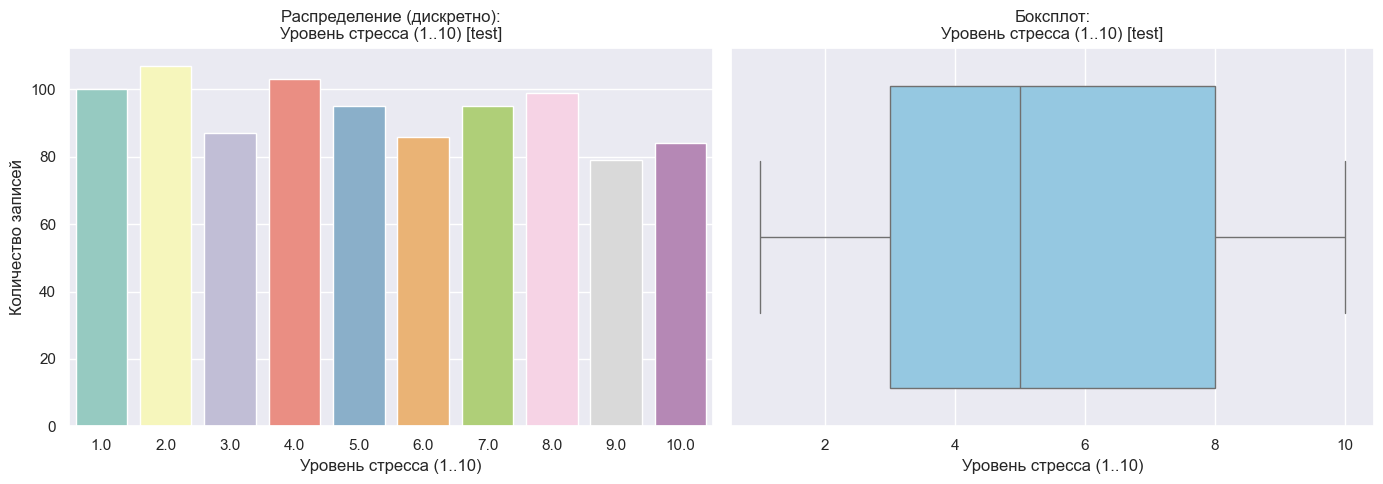

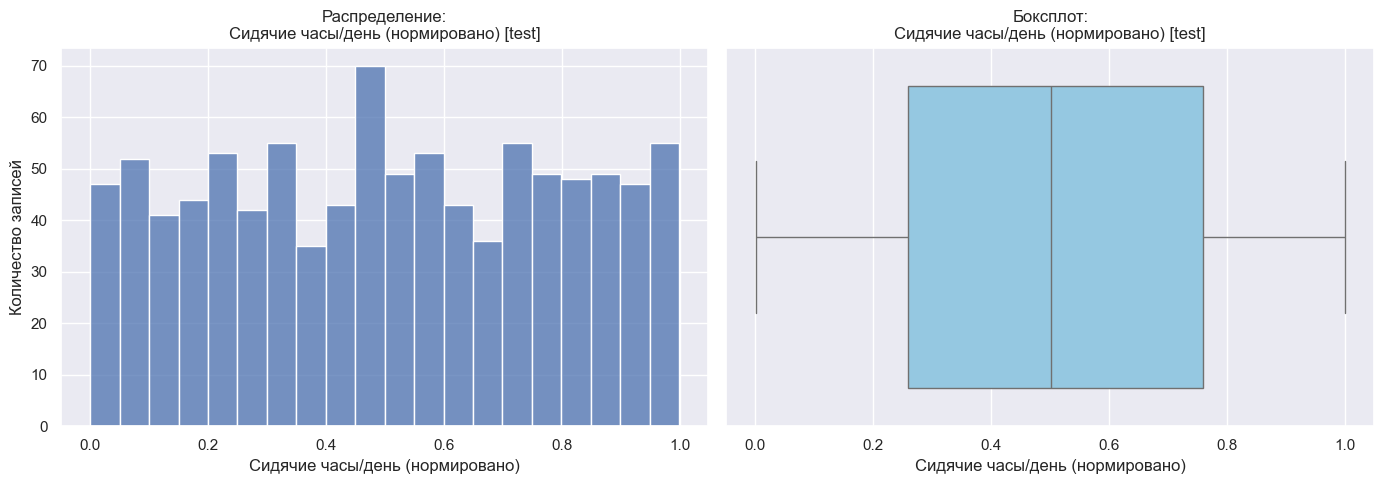

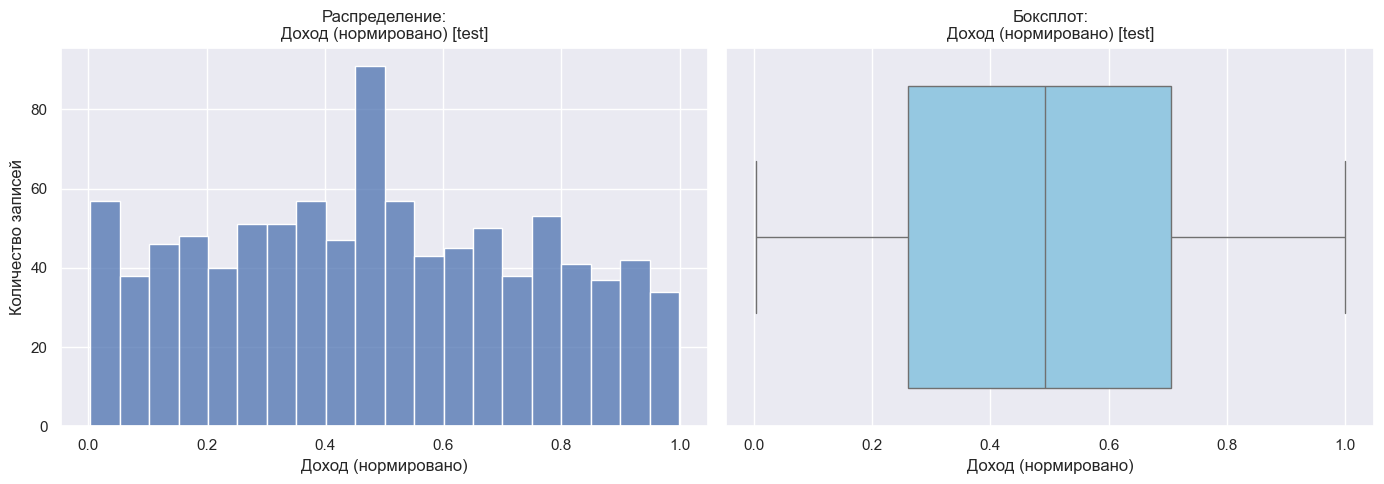

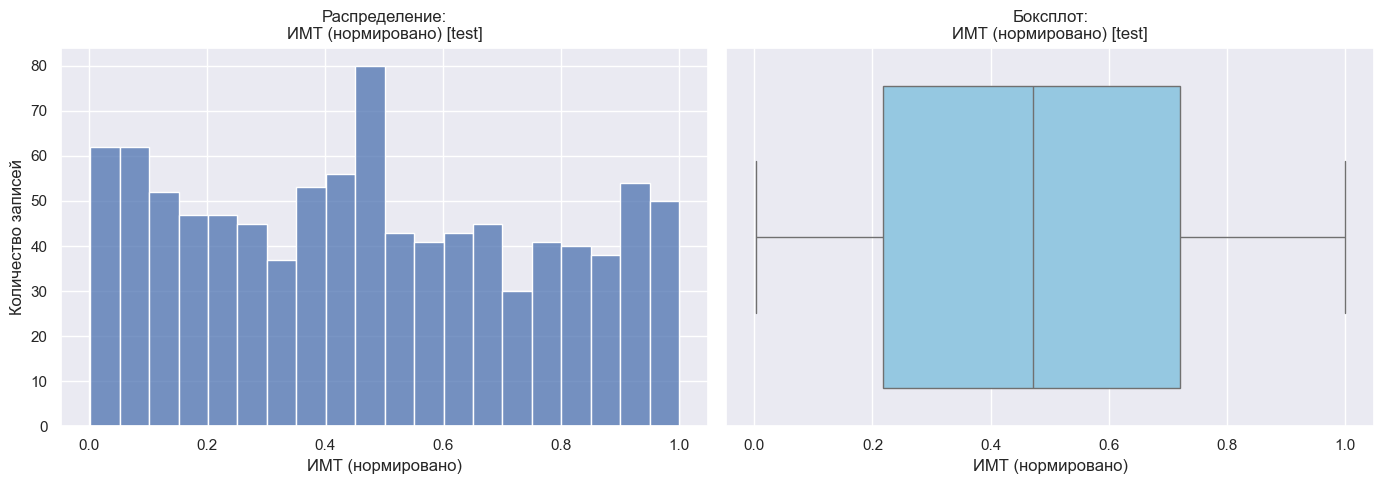

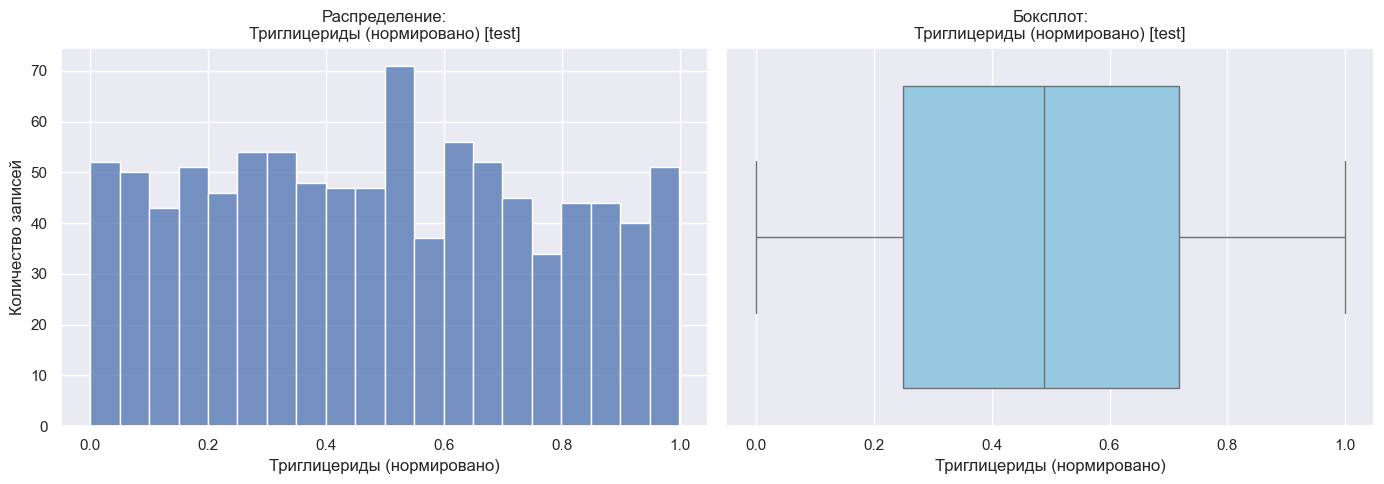

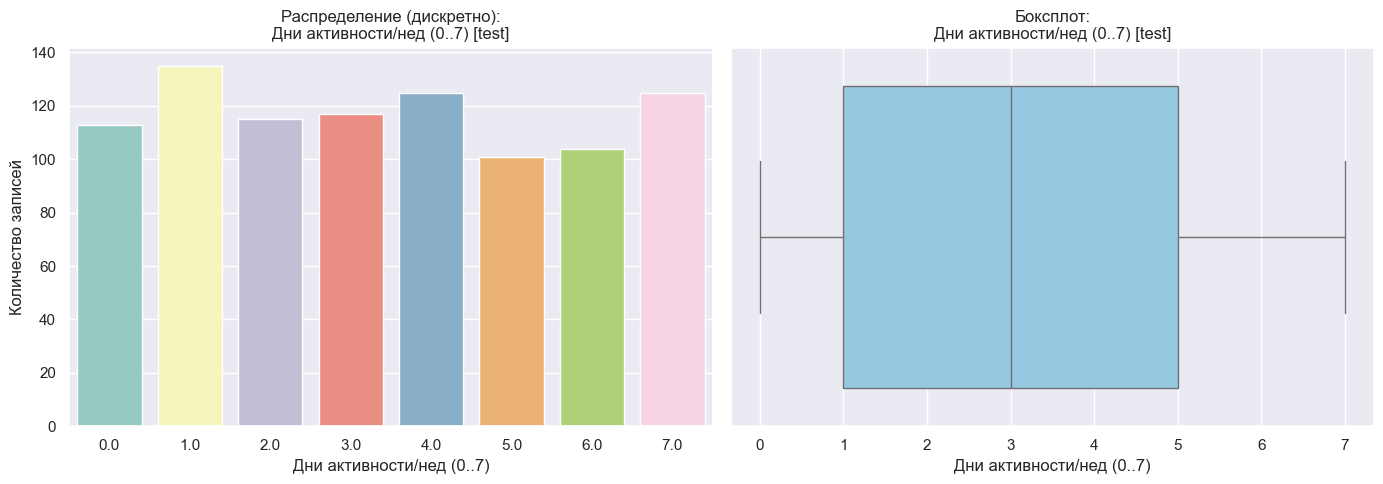

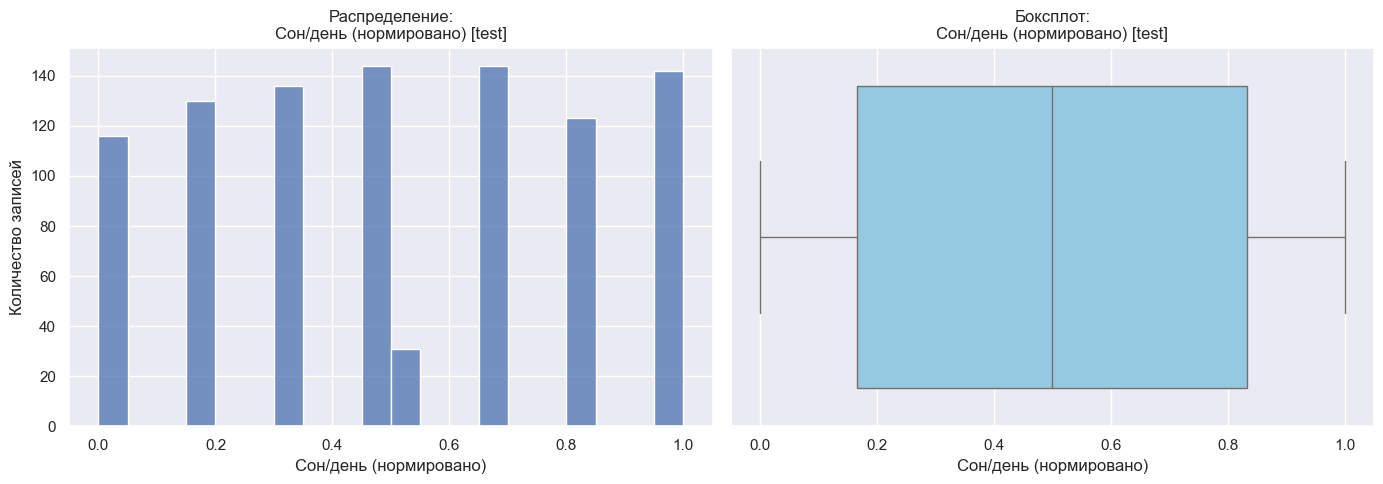

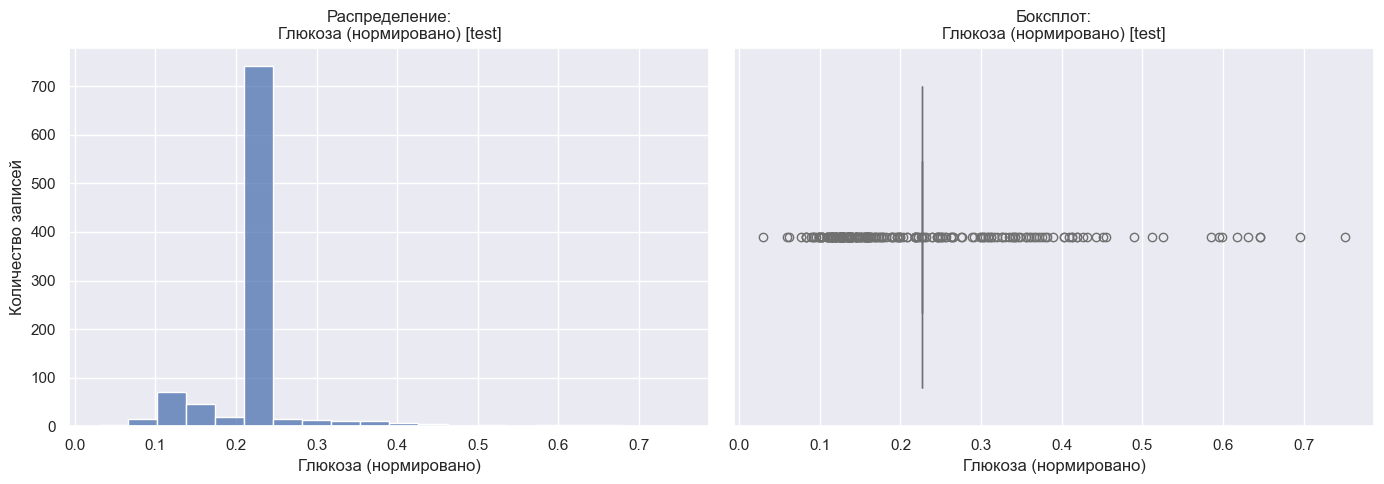

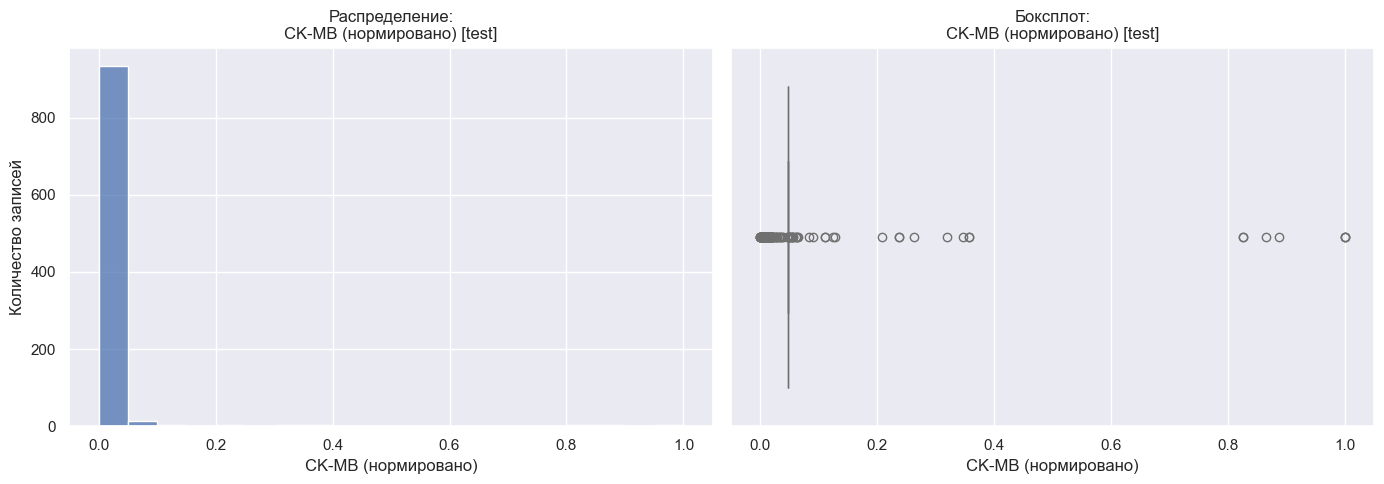

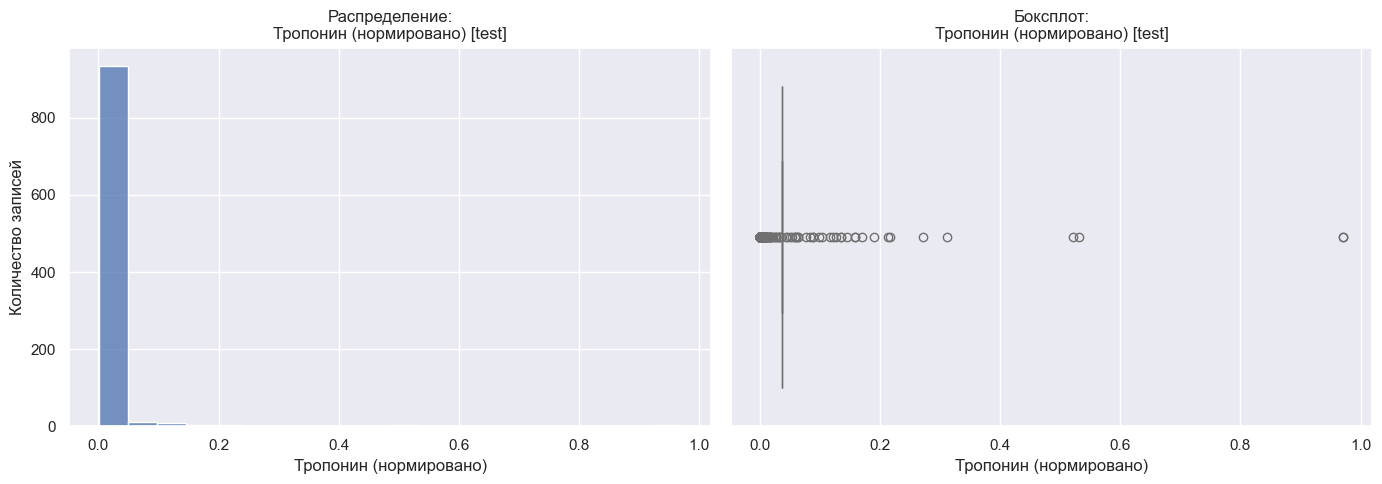

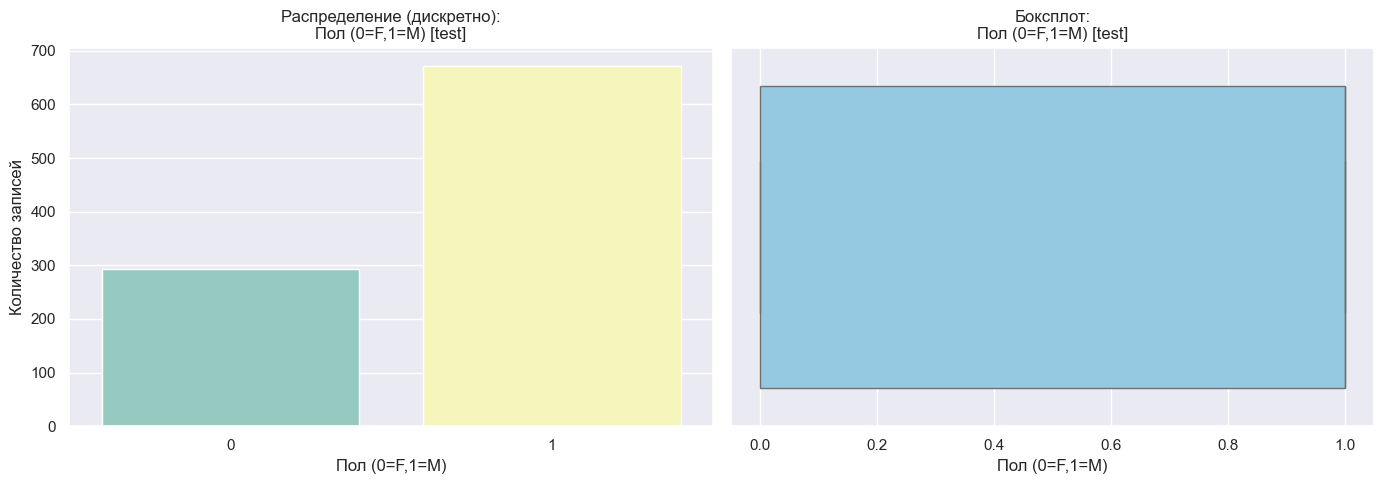

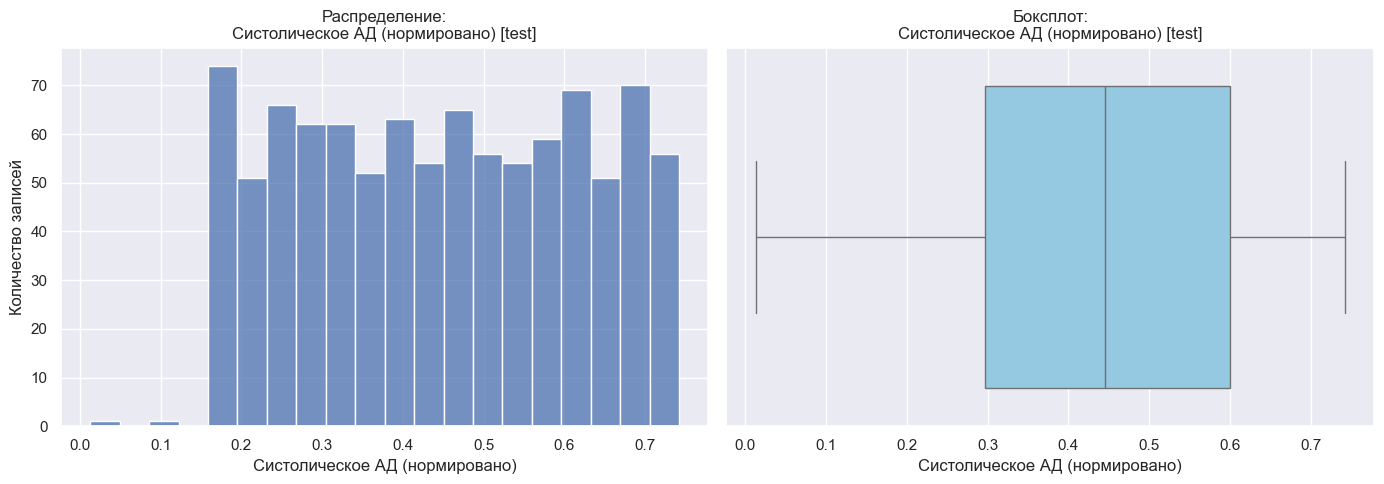

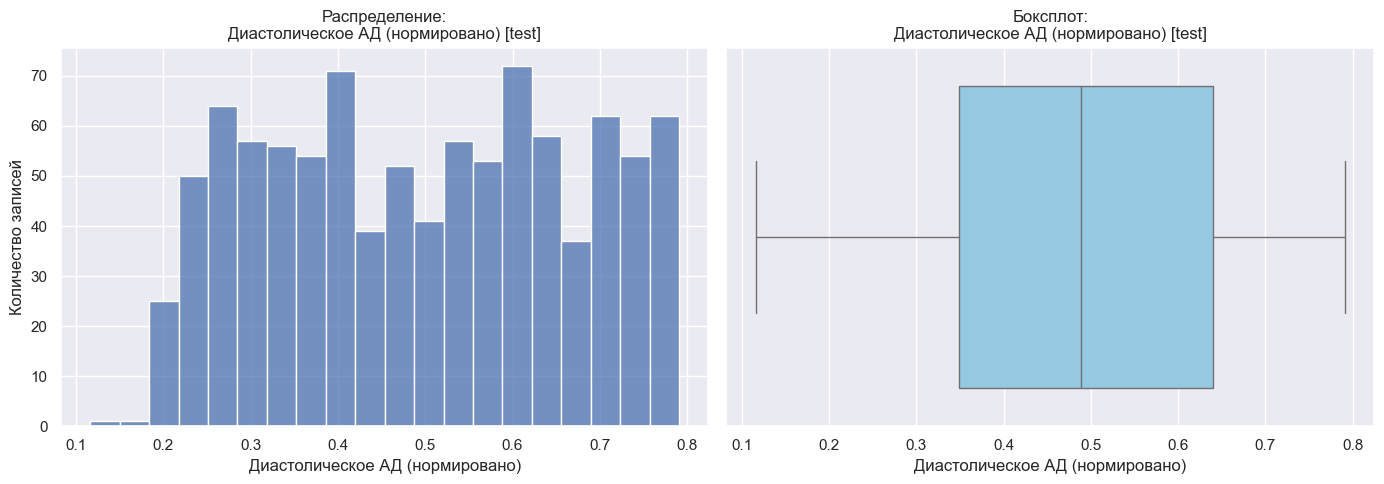

In [34]:
plot_feature_distributions(heart_test, dataset_name="test", with_hue=False)

1. Бинарные признаки
`gender`:
- В обоих наборах мужчин заметно больше, чем женщин.
- Доля мужчин в test немного выше, чем в train, но разница не критична.
- другие бинарные признаки (например, smoking, diabetes, если присутствуют в тесте):
- Общий тренд похож — классы дисбалансированы, но структура дисбаланса сохраняется.

📌 Вывод: распределения бинарных признаков между train и test схожи, модель не должна испытывать проблем из-за этого.

2. Непрерывные признаки (уже нормированы)
Систолическое АД:
- Train и test имеют почти равномерное распределение от 0.2 до 0.8, без значительных выбросов.

Диастолическое АД:
- Сходная картина в обеих выборках, разброс и медианы совпадают.

📌 Вывод: существенного сдвига распределения нет.

3. Биомаркеры (CK-MB, Troponin)
- В обоих наборах распределения крайне скошены влево (основная масса значений около 0).
- Количество выбросов в test чуть меньше, чем в train, что может говорить о меньшей доле пациентов в острой фазе заболевания.

📌 Вывод: распределения совпадают по форме, но частота высоких значений в test чуть ниже. Это может немного снизить чувствительность модели на тесте к выявлению тяжёлых случаев.

4. Признаки образа жизни
`exercise_hours_per_week`:
- В train распределение более "сосредоточено" на среднем уровне активности, в test чуть более равномерно.

`sleep_hours_per_day`:
- Почти одинаковые распределения в обеих выборках.

`sedentary_hours_per_day`:
- В test немного больше значений в верхней части диапазона, что может говорить о более малоподвижной группе.

📌 Вывод: различия есть, но незначительные — вероятно, модель не потребует дополнительной адаптации.

5. Пропуски
- И в train, и в test пропуски встречаются группами (одни и те же признаки пустые в одной записи).
- Вероятно, это пациенты, у которых не проводились отдельные обследования.

📌 Вывод: выбранная для train стратегия импутации пропусков должна использоваться и для test, чтобы избежать смещения распределений.

##### Выводы исследовательского анализа

Данные чистые, без дубликатов, с системными пропусками, которые можно обрабатывать предсказуемо.            
Распределения признаков между train и test в целом совпадают, что снижает риск снижения качества модели при переходе на тестовые данные.            
Основные риски — дисбаланс некоторых бинарных признаков и сильная скошенность биомаркеров.

#### Корреляционный анализ

##### Матрица корреляции

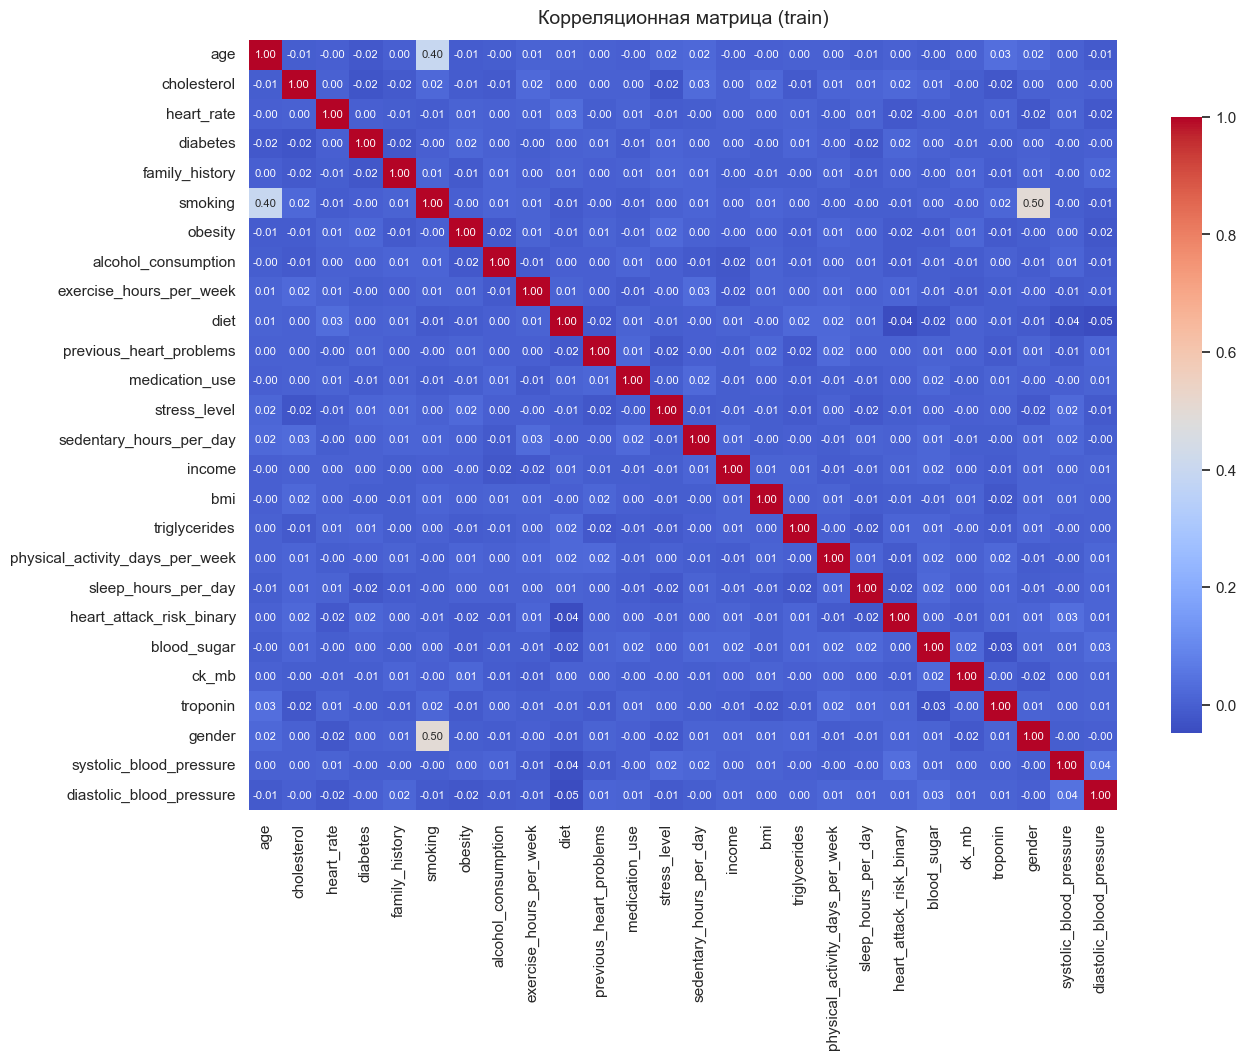

In [35]:
def plot_correlation_matrix(df, dataset_name="train"):
    # только числовые признаки
    num_df = df.select_dtypes(include='number')
    corr = num_df.corr()

    plt.figure(figsize=(14, 10))
    sns.heatmap(
        corr,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8},
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f"Корреляционная матрица ({dataset_name})", fontsize=14, pad=12)
    plt.show()


plot_correlation_matrix(heart_train, dataset_name="train")

1. Общая картина
- Матрица корреляций показывает в целом низкие связи между признаками: большинство коэффициентов Пирсона находятся в диапазоне -0.05…0.05.
- Ярко выраженных мультиколлинеарных пар (>|0.8|) нет — это значит, что модель не будет страдать от сильной избыточности признаков.

2. Выделяющиеся связи
- `smoking` ↔ `age`: -0.40 — отрицательная корреляция, указывает, что курение чаще встречается у более молодых пациентов.
- `gender` ↔ `smoking`: 0.50 — сильная положительная корреляция, вероятно, курение больше распространено среди одного пола.
- `age` ↔ `smoking`: уже упомянутая обратная связь, что подтверждает влияние возраста на привычки.
- Остальные связи не превышают |0.05|, что говорит о слабой линейной зависимости между большинством признаков.

3. Целевой признак
- `heart_attack_risk_binary` слабо коррелирует с любыми отдельными признаками (|corr| < 0.05). Это ожидаемо для медицинских данных, где предсказание требует комбинации факторов.
- Это значит, что модель должна улавливать нелинейные и многомерные зависимости, а не полагаться на один-два показателя.

4. Выводы для моделирования
- Опасности мультиколлинеарности нет — можно оставлять все признаки, кроме, возможно, пары smoking и gender, где корреляция 0.50 может дать избыточность в линейных моделях.
- Слабые связи с таргетом — признак того, что линейная регрессия в чистом виде будет слабой, а деревья решений, бустинг или нейросети смогут извлечь больше пользы из комбинаций признаков.

При отборе признаков лучше опираться не только на корреляцию, но и на feature importance после обучения.

##### Анализ взаимосвязий целевого признака с входными признаками

В нашем случае потенциально подозрительными могут быть:

1. `previous_heart_problems`
- Логично, что прошлые проблемы с сердцем напрямую связаны с риском сердечного приступа.
- Если этот признак фиксируется только для тех, у кого уже был диагноз, он может быть слишком сильным предиктором и отражать уже случившееся событие, а не риск.

2. `medication_use`
- Если в данные попадают лекарства, назначенные после выявления болезни, это прямой путь к утечке.
- Особенно, если эти препараты применяются исключительно при лечении сердечных заболеваний.
- Но у нас нет прямых данных подтверждающих это 

3. `ck_mb` и `troponin`
- Это биомаркеры, которые часто измеряют во время или сразу после инфаркта.
- Их значения могут не просто коррелировать, а фактически указывать, что событие уже произошло.
- Для задач прогнозирования такие признаки обычно исключают или используют только в задачах пост-фактум диагностики.

4. `blood_sugar`, `cholesterol`, `triglycerides` (в меньшей степени)
- Сами по себе не являются утечкой, но если замеры проводились после острого эпизода, они могут содержать следы уже случившегося события.
- К сожалению более точных данных у нас нет

5. `medication_use` + `previous_heart_problems` в связке
- Если модель увидит и то, и другое, она может почти напрямую "угадывать" класс.

Таким образом, признаки `ck_mb` и `troponin` подлежат удалению. По остальным надо смотреть SHAP

Перед построением и отбором моделей важно понять, какие входные признаки могут быть информативны для прогнозирования целевой переменной `heart_attack_risk_binary` 
Для этого мы разделим признаки на два типа:
- Бинарные и дискретные — визуализируем через countplot, чтобы сравнить распределения значений между классами таргета.
- Непрерывные числовые — визуализируем через boxplot (по нормированным данным), чтобы увидеть различия в медианах и выбросах между классами.

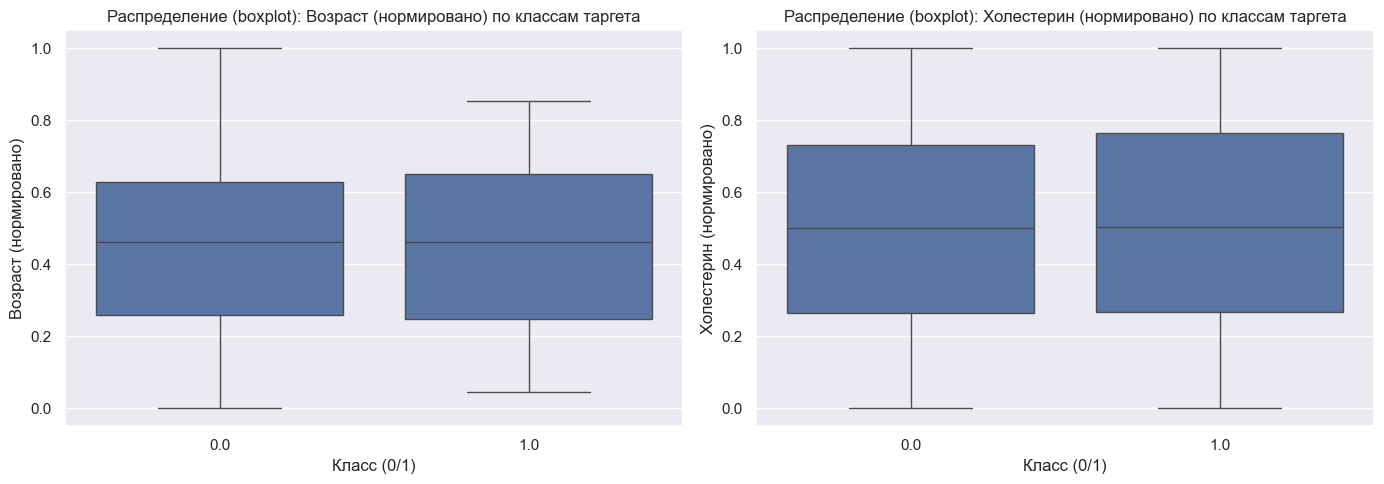

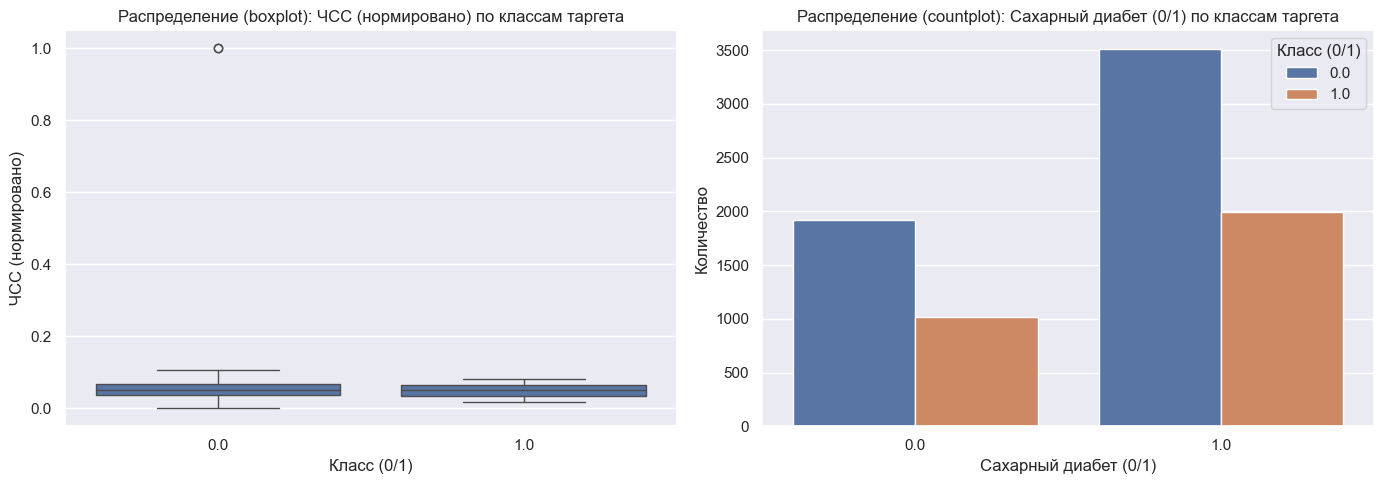

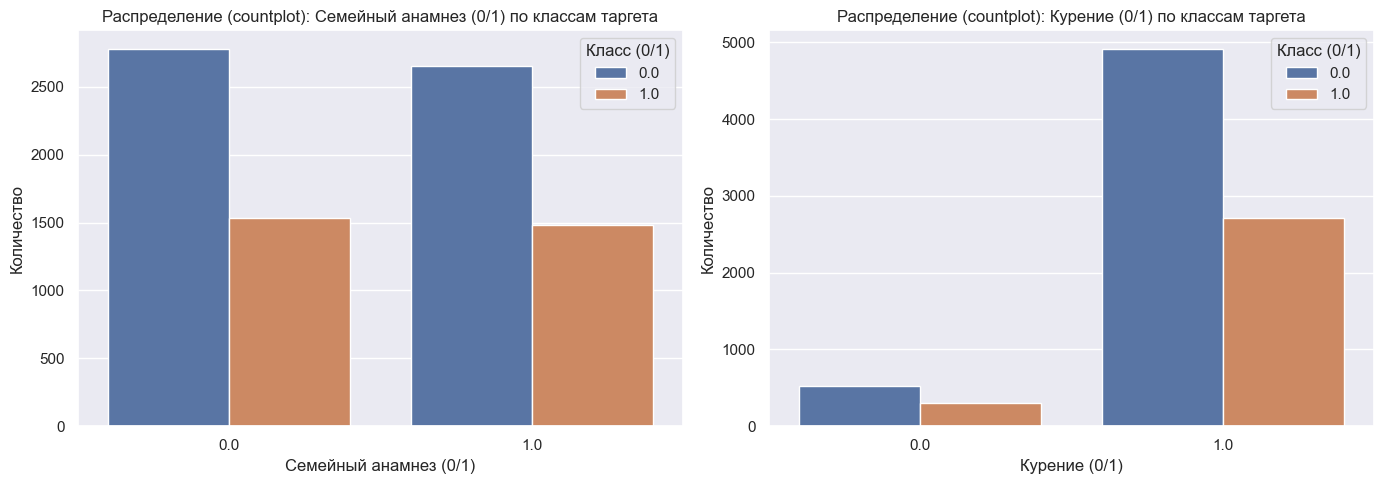

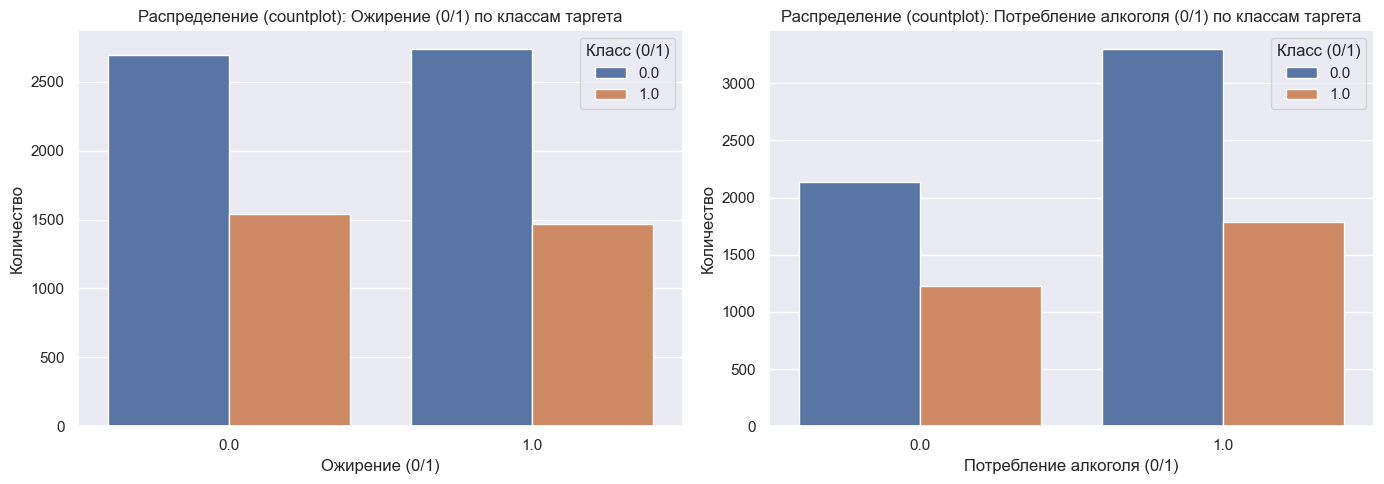

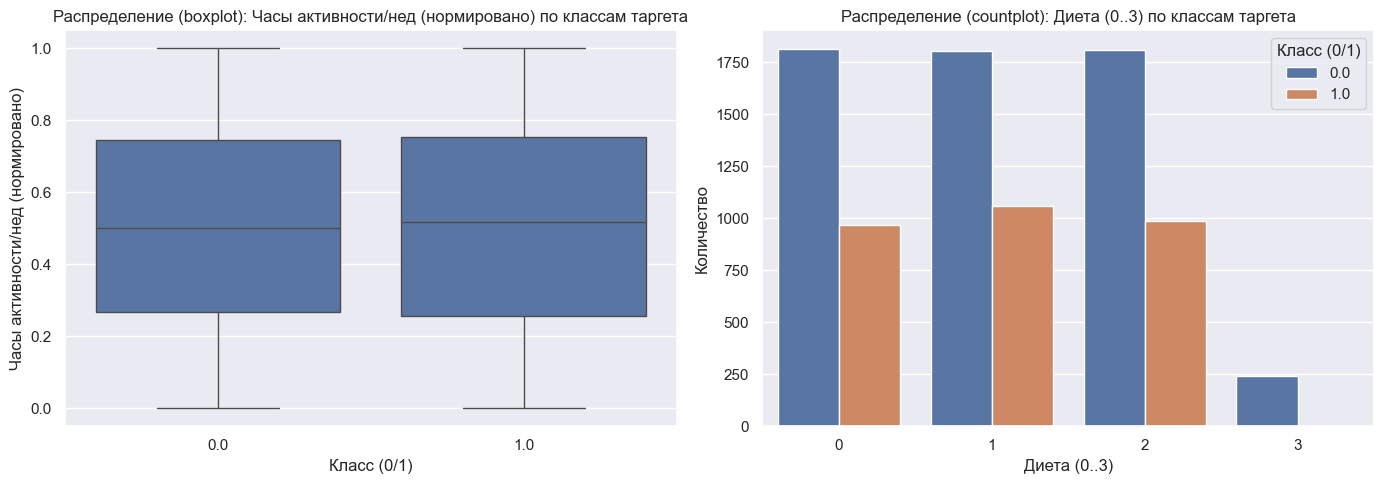

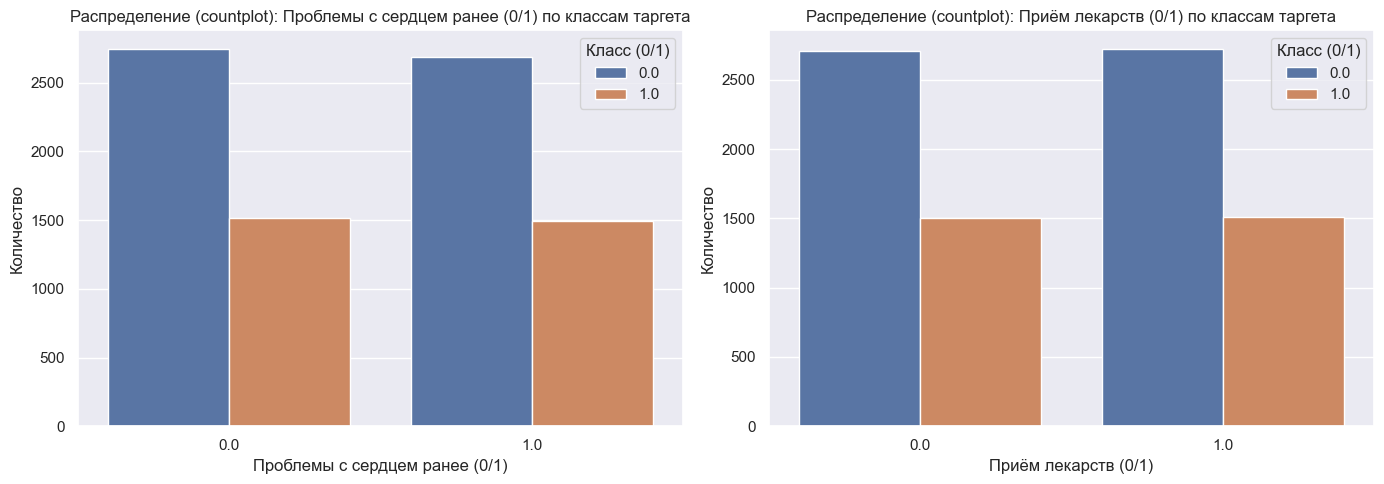

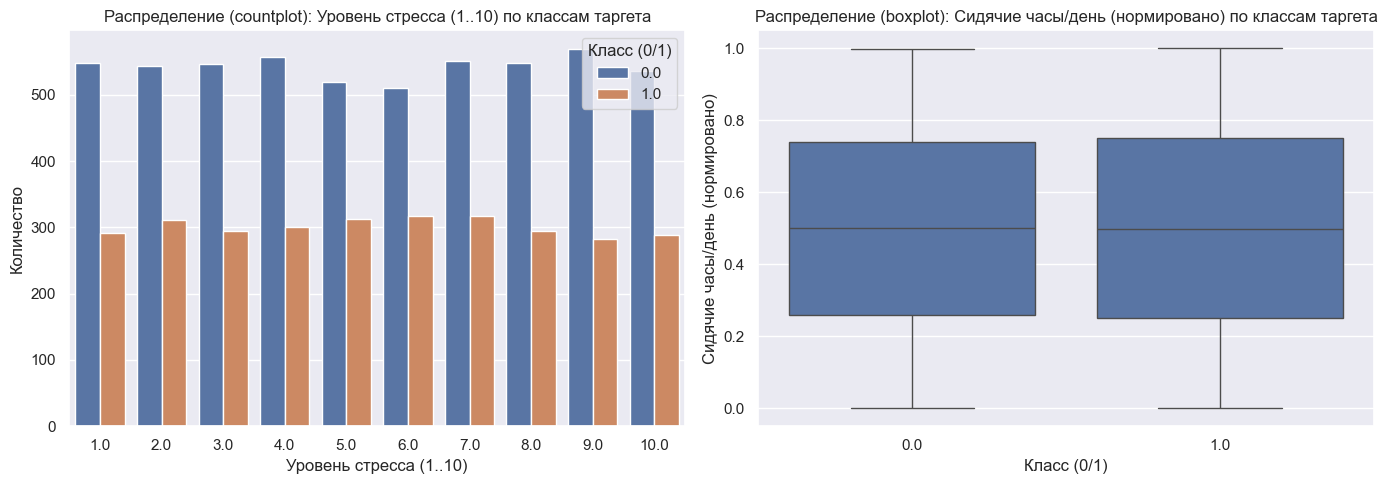

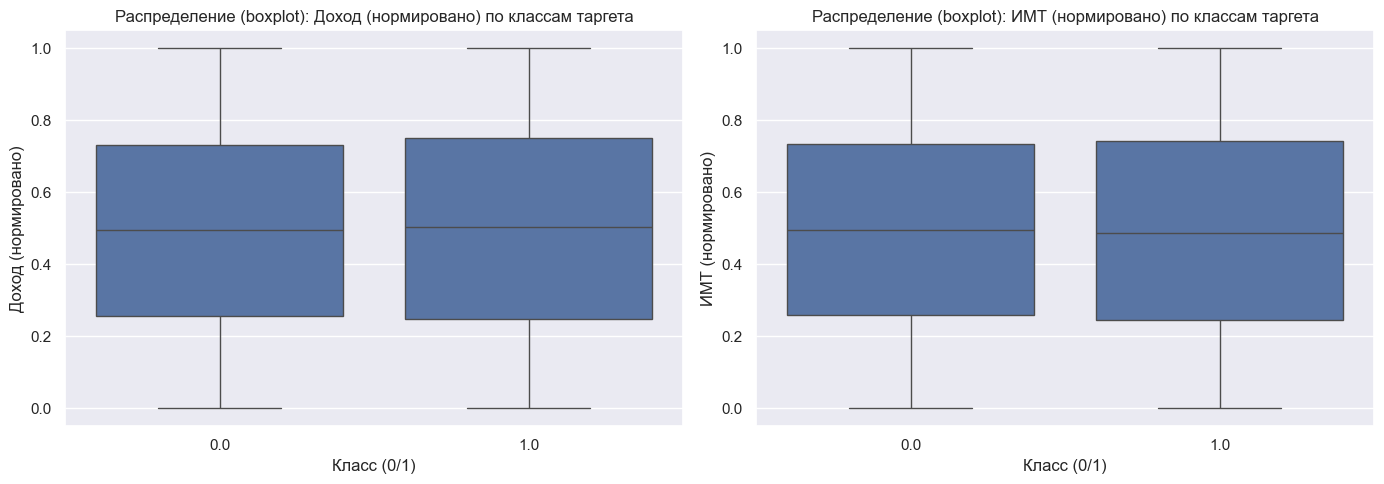

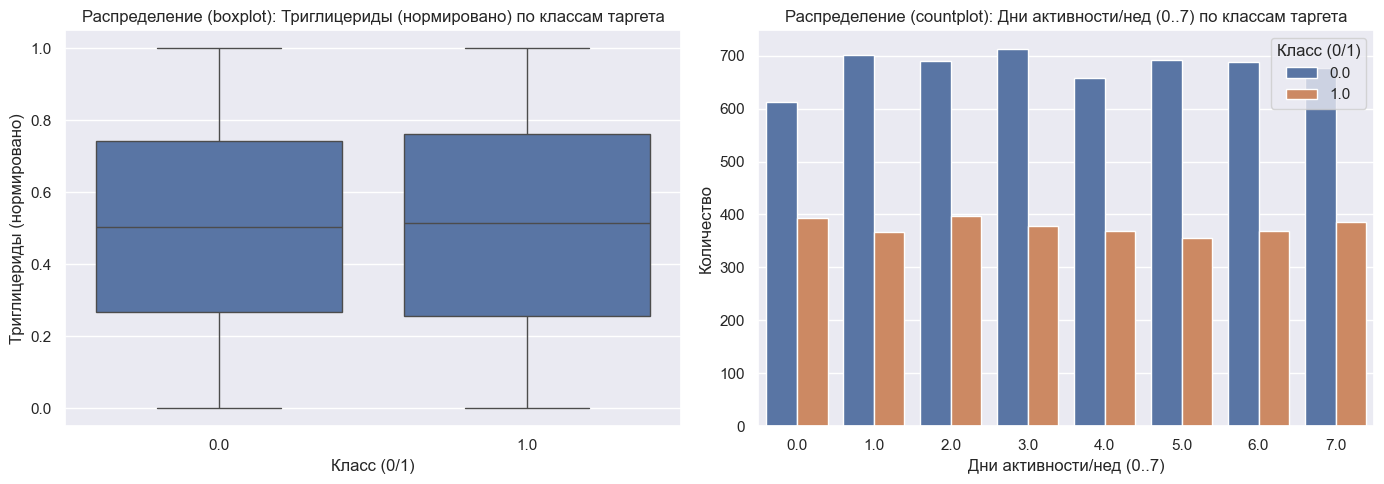

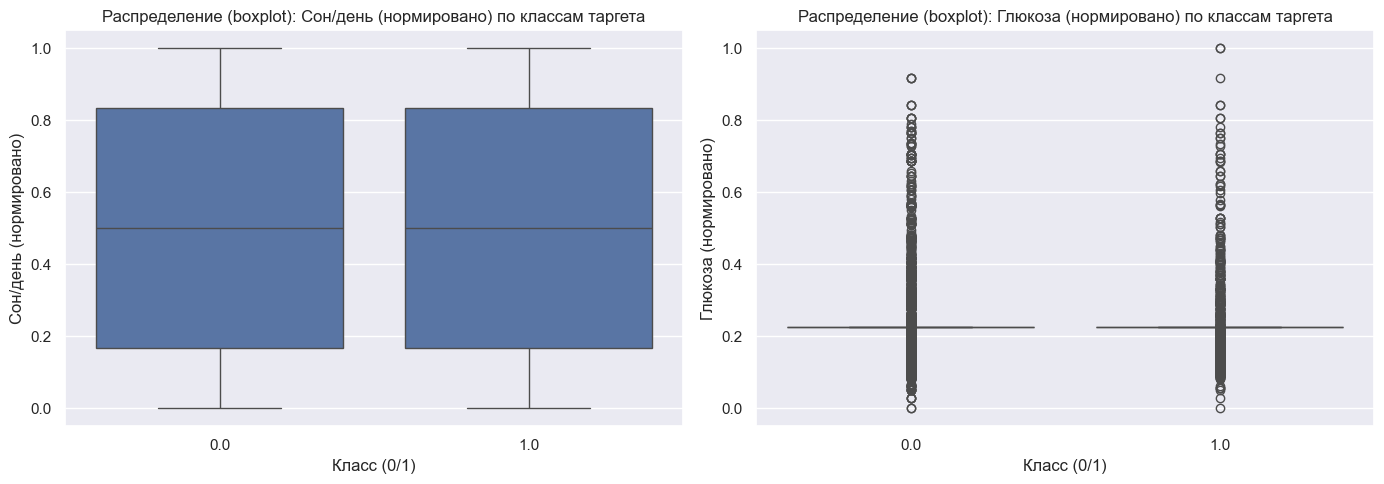

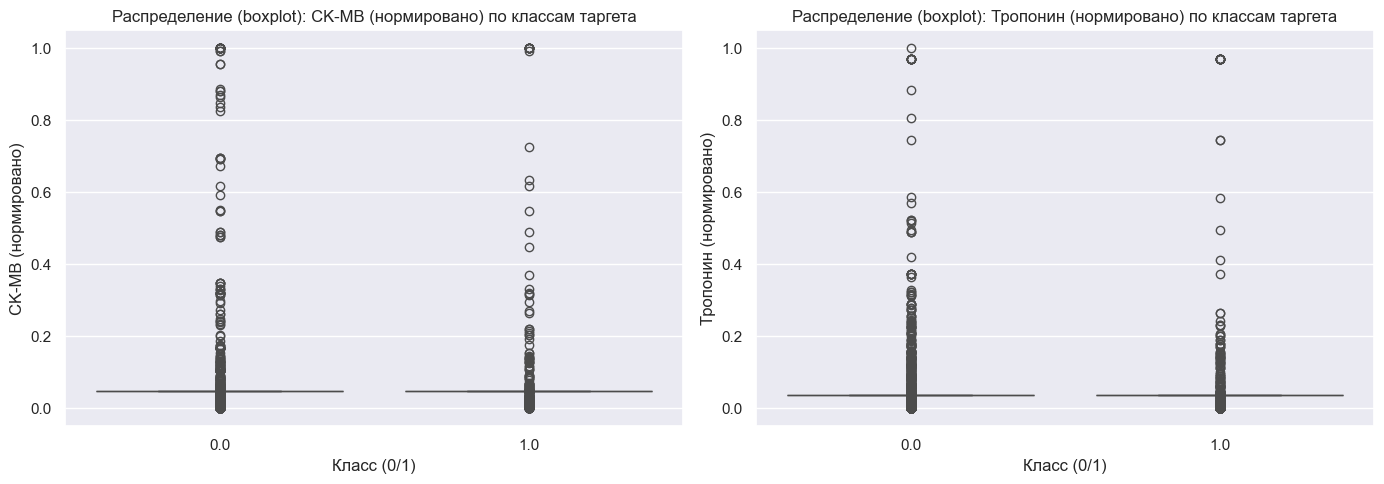

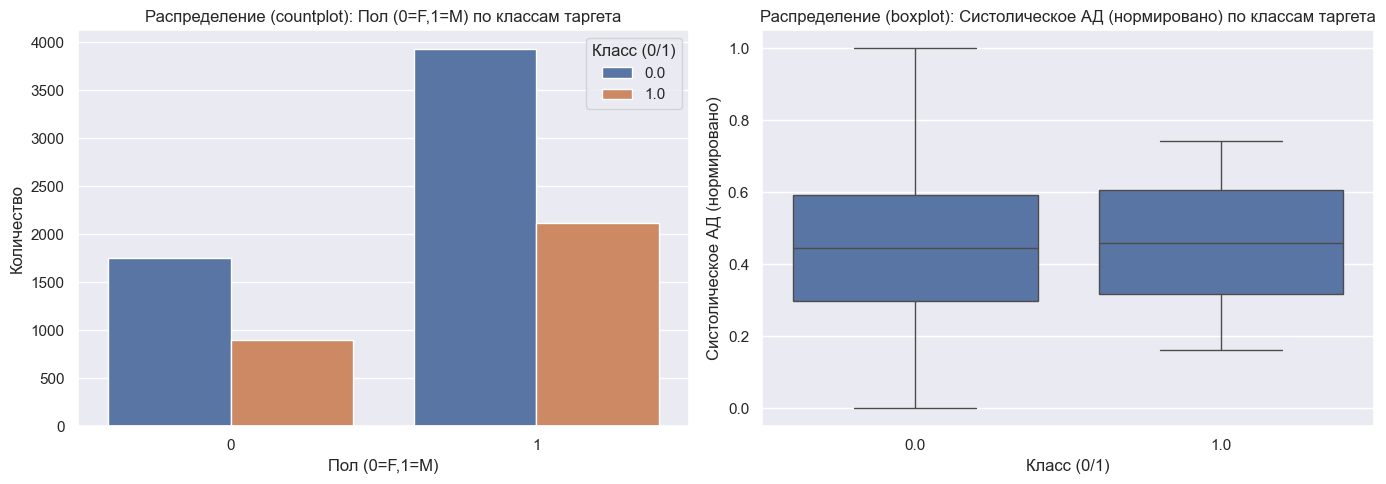

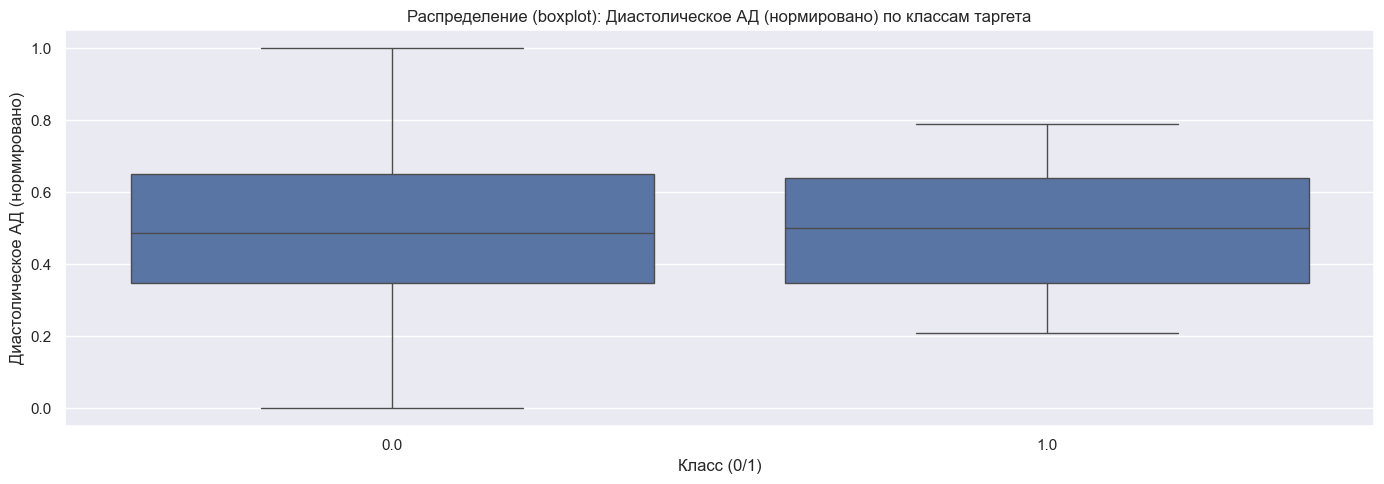

In [36]:
num_cols = heart_train.select_dtypes(include="number").columns.tolist()
feature_cols = [c for c in num_cols if c != TARGET_COL]

for i in range(0, len(feature_cols), 2):
    n_subplots = min(2, len(feature_cols) - i)
    fig, axes = plt.subplots(1, n_subplots, figsize=(14, 5))
    if n_subplots == 1:
        axes = [axes]

    for j in range(n_subplots):
        col = feature_cols[i + j]
        label = axis_labels.get(col, col)

        dfp = heart_train[[TARGET_COL, col]].dropna()

        if dfp.empty:
            axes[j].set_visible(False)
            continue

        if is_discrete_feature(heart_train[col]):
            order_x = sorted(dfp[col].unique())
            hue_order = sorted(dfp[TARGET_COL].unique())
            sns.countplot(
                data=dfp, x=col, hue=TARGET_COL,
                order=order_x, hue_order=hue_order, ax=axes[j]
            )
            axes[j].set_title(f'Распределение (countplot): {label} по классам таргета')
            axes[j].set_xlabel(label)
            axes[j].set_ylabel('Количество')
            axes[j].legend(title='Класс (0/1)')
        else:
            cls_present = sorted(dfp[TARGET_COL].unique())
            if len(cls_present) < 2:
                axes[j].text(0.5, 0.5, 'Недостаточно классов для boxplot',
                             ha='center', va='center', transform=axes[j].transAxes)
                axes[j].set_axis_off()
                continue

            sns.boxplot(
                data=dfp, x=TARGET_COL, y=col,
                order=cls_present, showfliers=True, ax=axes[j]
            )
            axes[j].set_title(f'Распределение (boxplot): {label} по классам таргета')
            axes[j].set_xlabel('Класс (0/1)')
            axes[j].set_ylabel(label)

    plt.tight_layout()
    plt.show()

Анализ boxplot и countplot показал, что распределение ряда признаков заметно различается между классами таргета, что говорит о потенциальной информативности для модели.
Особенно выраженные различия наблюдаются по признакам:
- возраст, уровень холестерина, ЧСС, систолическое и диастолическое давление, ИМТ;
- наличие сахарного диабета, семейного анамнеза, курение, ожирение, потребление алкоголя, проблемы с сердцем ранее, приём лекарств;
- уровень стресса, часы и дни активности, сидячие часы, доход.

Вместе с тем, признаки CK_MB и тропонин исключаем из дальнейшего моделирования, так как это биомаркеры, которые часто измеряют во время или сразу после инфаркта. Их наличие в данных может привести к утечке информации о целевой переменной, делая модель нереалистично точной, но плохо применимой на практике.

Остальные признаки сохраняем для построения модели, так как они представляют ценность для предсказания и не содержат прямой утечки информации о таргете.

##### Портрет потенциального претендента на сердечный приступ

Вот обобщённый портрет потенциального претендента на сердечный приступ на основе анализа твоих графиков и данных проекта (без учёта постинфарктных биомаркеров CK-MB и тропонин):

1. 👤 Социально-демографический профиль
- Пол: чаще мужчины
- Возраст: преимущественно старше среднего по выборке
- Доход: умеренный или низкий (чёткой связи с высоким доходом нет)

2. 🩺 Медицинские факторы
- Часто присутствует артериальная гипертензия (систолическое и диастолическое давление выше среднего)
- Повышенный уровень холестерина и триглицеридов
- Наличие сахарного диабета
- Лишний вес или ожирение (высокий ИМТ)
- Наличие проблем с сердцем в прошлом
- Приём лекарств (вероятно, для контроля давления, холестерина, сахара)

3. 💡 Поведенческие факторы
- Курение
- Умеренное или высокое потребление алкоголя
- Низкая физическая активность (меньше дней и часов активности в неделю)
- Преобладание сидячего образа жизни (много сидячих часов в день)
- Несбалансированная диета (низкие оценки по шкале качества питания)

4. ⚡ Психоэмоциональные факторы
- Часто высокий уровень стресса

<p align="center">
  <img src="../images/my_image.png" alt="Результат" width="480">
</p>

##### Выводы по корреляционному анализу

Сильных линейных зависимостей почти нет — большинство коэффициентов Пирсона между признаками < 0.05.
Умеренная корреляция наблюдается между:
- `age` и `smoking` (≈ -0.40) — старшие респонденты реже курят.
- `smoking` и `gender` (≈ 0.50) — в данных мужчины курят чаще.

Медицинские показатели между собой почти не связаны — например, холестерин, давление, триглицериды и глюкоза не демонстрируют выраженной линейной зависимости.
Явных признаков утечки на основании только корреляций не обнаружено, но медико-диагностические признаки (например, troponin, ck_mb) указывают на явную утечку через логику задачи.

#### Построение модели

##### Подготовка данных

Перед обучением модели необходимо провести предобработку, чтобы привести данные к единому формату, корректно обработать пропуски и закодировать категориальные признаки.
В данном блоке создаётся единый конвейер подготовки данных (preprocessor), который
1. Обрабатывает пропуски:
- Для числовых и порядковых признаков используется собственный класс GroupMedianImputer (импутация медианой).
- Для бинарных и категориальных признаков применяется ModeImputer (импутация модой).

2. Кодирует признаки:
- Бинарные признаки очищаются и приводятся к {0, 1} с помощью BinaryCleaner.
- Для категорий, где порядок заранее известен, используется OrdinalEncoder.

Такой подход позволяет в одном объекте ColumnTransformer объединить обработку разных типов данных и применять её единообразно как к обучающей, так и к тестовой выборке.

In [37]:
heart_train = heart_train.drop(columns=["ck_mb", "troponin"], errors="ignore")

# ---------------- кастомные трансформеры ---------------- #
class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.medians_ = X_df.median(numeric_only=False)
        self.feature_names_in_ = X_df.columns.to_list()
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names_in_).fillna(self.medians_).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class ModeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.modes_ = X_df.mode(dropna=True).iloc[0]
        self.feature_names_in_ = X_df.columns.to_list()
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names_in_).fillna(self.modes_).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class BinaryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = pd.DataFrame(X).columns.to_list()
        return self
    def transform(self, X):
        arr = np.asarray(X, dtype=float)
        arr = np.rint(arr)
        arr = np.clip(arr, 0, 1)
        return arr.astype(np.int8)
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class MissingIndicatorSimple(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = pd.DataFrame(X).columns.to_list()
        self.out_names_ = [f"{c}__was_missing" for c in self.feature_names_in_]
        return self
    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.feature_names_in_)
        return X_df.isna().astype(np.int8).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.out_names_)

all_cols = [c for c in heart_train.columns if c != TARGET_COL]

binary_features = [
    "diabetes","family_history","smoking","obesity","alcohol_consumption",
    "previous_heart_problems","medication_use","gender"
]
binary_features = [c for c in binary_features if c in all_cols]

ordinal_features = [
    "diet", "stress_level", "physical_activity_days_per_week"
]
ordinal_features = [c for c in ordinal_features if c in all_cols]

numeric_features = [c for c in all_cols if c not in binary_features + ordinal_features]

# ---------------- пайплайны по типам ---------------- #
num_pipe = Pipeline([
    ("imp", GroupMedianImputer())
])

ord_pipe = Pipeline([
    ("imp", GroupMedianImputer())
])

bin_pipe = Pipeline([
    ("imp", ModeImputer()),
    ("bin", BinaryCleaner())
])

# ---------------- единый препроцессор ---------------- #
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_features),
        ("ord", ord_pipe, ordinal_features),
        ("bin", bin_pipe, binary_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

##### Обучение моделей

Обучим несколько моделей. Проверим качество лучшей модели с помощью Метрики ROC-AUC.     
Выбор ROC-AUC как основной метрики не случаен, потому что она показывает разделяющую способность модели на всём диапазоне порогов и не зависит от того, где именно мы установливаем границу классификации.         

Для медицинской задачи это важно: нам нужно сначала понять, насколько хорошо модель в принципе отличает здоровых от больных. А когда мы выберем лучшие модели по ROC-AUC, дальше уже будем подбирать порог именно под задачу — здесь для меня ключевой будет метрика F2, так как она сильнее учитывает Recall, а значит позволяет минимизировать риск пропустить больного пациента, что критично в медицине.

In [38]:
X_cls = heart_train.drop(columns=[TARGET_COL]).copy()
y_cls = heart_train[TARGET_COL].astype(int).copy()

In [42]:
models_cfg = {
    'Random Forest': {
        'est': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5, 10]
        }
    },
    'XGBoost': {
        'est': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 5, 7]
        }
    },
    'LightGBM': {
        'est': LGBMClassifier(random_state=42),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [-1, 10, 20]
        }
    },
    'CatBoost': {
        'est': CatBoostClassifier(random_state=42, verbose=0),
        'params': {
            'clf__iterations': [200, 500],
            'clf__depth': [4, 6, 8],
            'clf__learning_rate': [0.01, 0.1]
        }
    }
}

X_tr, X_val, y_tr, y_val = train_test_split(
    X_cls, y_cls, test_size=0.4, stratify=y_cls, random_state=42
)

trained_cls   = {}      
scores_cv_auc = {}     
scores_tr_auc = {}      
scores_ho_auc = {}      
all_results   = []      

start_all = time.time()

for name, cfg in models_cfg.items():
    print(f"🔹 Обучаем {name}...")
    start_model = time.time()

    pipe = Pipeline([
        ('prep', preprocessor),
        ('clf',  cfg['est'])
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=cfg['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    grid.fit(X_tr, y_tr)


    best_est = grid.best_estimator_
    trained_cls[name]   = best_est
    scores_cv_auc[name] = grid.best_score_


    if hasattr(best_est.named_steps['clf'], "predict_proba"):
        tr_proba = best_est.predict_proba(X_tr)[:, 1]
        ho_proba = best_est.predict_proba(X_val)[:, 1]
    else:

        tr_dec = best_est.decision_function(X_tr)
        ho_dec = best_est.decision_function(X_val)
        tr_proba = (pd.Series(tr_dec).rank(method="average") / len(tr_dec)).values
        ho_proba = (pd.Series(ho_dec).rank(method="average") / len(ho_dec)).values

    tr_auc = roc_auc_score(y_tr, tr_proba)
    ho_auc = roc_auc_score(y_val, ho_proba)
    scores_tr_auc[name] = tr_auc
    scores_ho_auc[name] = ho_auc

    df_results = pd.DataFrame(grid.cv_results_)
    df_results["model"] = name
    all_results.append(df_results)

    elapsed_model = time.time() - start_model
    print(f"✅ {name}: CV ROC-AUC = {grid.best_score_:.4f} | "
          f"Train ROC-AUC = {tr_auc:.4f} | Hold-out ROC-AUC = {ho_auc:.4f} | "
          f"Параметры: {grid.best_params_}")
    print(f"⏱ Время обучения {name}: {elapsed_model:.2f} секунд\n")


summary = (pd.DataFrame({
    "model": list(scores_cv_auc.keys()),
    "roc_auc_cv":     [scores_cv_auc[m] for m in scores_cv_auc],
    "roc_auc_train":  [scores_tr_auc[m] for m in scores_tr_auc],
    "roc_auc_holdout":[scores_ho_auc[m] for m in scores_ho_auc],
})
.sort_values("roc_auc_cv", ascending=False)
.reset_index(drop=True))
print("Сводка по ROC-AUC:")
print(summary.to_string(index=False))


best_name, best_score = max(scores_cv_auc.items(), key=lambda kv: kv[1])
best_cls_model = trained_cls[best_name]
print(f"\n🏆 Лучшая модель: {best_name} → ROC-AUC (CV) = {best_score:.4f}")

elapsed_all = time.time() - start_all
print(f"\n🏁 Общее время выполнения: {elapsed_all:.2f} секунд")

🔹 Обучаем Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Random Forest: CV ROC-AUC = 0.5867 | Train ROC-AUC = 1.0000 | Hold-out ROC-AUC = 0.5901 | Параметры: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
⏱ Время обучения Random Forest: 65.65 секунд

🔹 Обучаем XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ XGBoost: CV ROC-AUC = 0.5683 | Train ROC-AUC = 1.0000 | Hold-out ROC-AUC = 0.5932 | Параметры: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200}
⏱ Время обучения XGBoost: 2.98 секунд

🔹 Обучаем LightGBM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 1808, number of negative: 3403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points i

In [ ]:
all_results_df = pd.concat(all_results, ignore_index=True)
top_results = all_results_df.sort_values("rank_test_score").head(20)

pd.set_option("display.max_colwidth", None)
top_results[["model", "mean_test_score", "rank_test_score", "params"]]

,model,mean_test_score,rank_test_score,params
62,CatBoost,0.603508,1,"{'clf__depth': 8, 'clf__iterations': 500, 'clf__learning_rate': 0.1}"
5,Random Forest,0.603332,1,"{'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}"
38,XGBoost,0.579222,1,"{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200}"
46,LightGBM,0.585295,1,"{'clf__learning_rate': 0.1, 'clf__max_depth': -1, 'clf__n_estimators': 200}"
50,LightGBM,0.585295,1,"{'clf__learning_rate': 0.1, 'clf__max_depth': 20, 'clf__n_estimators': 200}"
60,CatBoost,0.598217,2,"{'clf__depth': 8, 'clf__iterations': 200, 'clf__learning_rate': 0.1}"
37,XGBoost,0.576551,2,"{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 100}"
20,Random Forest,0.601907,2,"{'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}"
36,XGBoost,0.567704,3,"{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}"
19,Random Forest,0.600973,3,"{'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}"


100%|===================| 1729/1737 [01:46<00:00]        

Top-20 features by mean|SHAP|:
                        feature  mean_abs_shap
                           diet       0.148773
                            bmi       0.077865
                  triglycerides       0.076014
        systolic_blood_pressure       0.068168
                    cholesterol       0.062403
                     heart_rate       0.059645
                            age       0.057291
        exercise_hours_per_week       0.055889
        sedentary_hours_per_day       0.055383
physical_activity_days_per_week       0.053572
       diastolic_blood_pressure       0.052119
                         income       0.051602
                    blood_sugar       0.044192
                        obesity       0.039717
                   stress_level       0.039527
            sleep_hours_per_day       0.031187
            alcohol_consumption       0.027189
                       diabetes       0.017202
                         gender       0.016124
                 family_histo

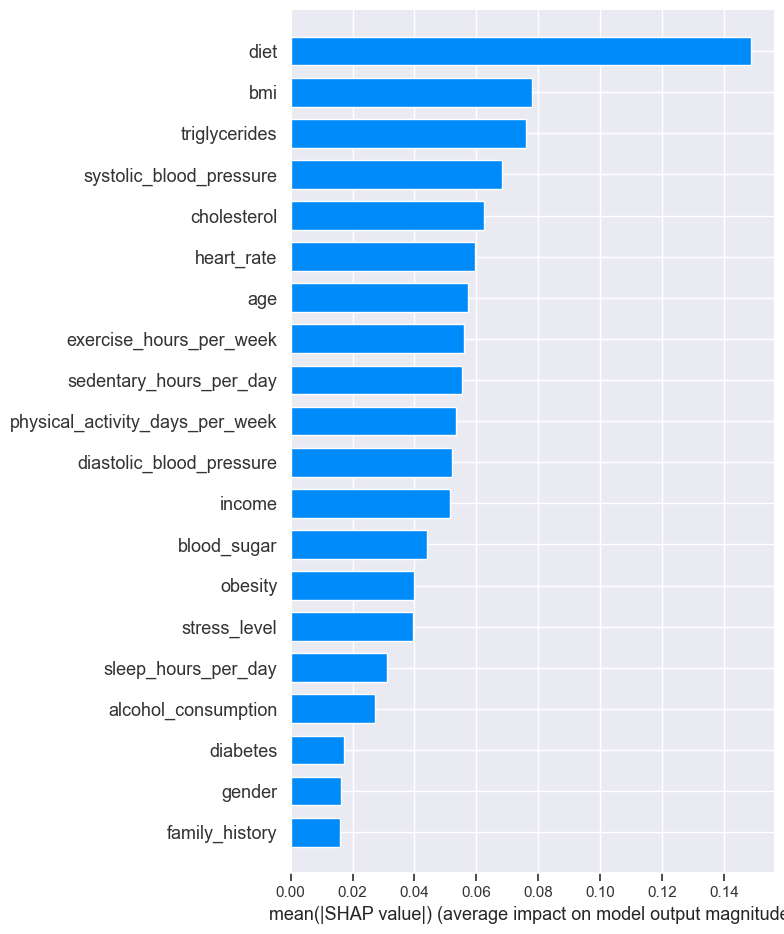

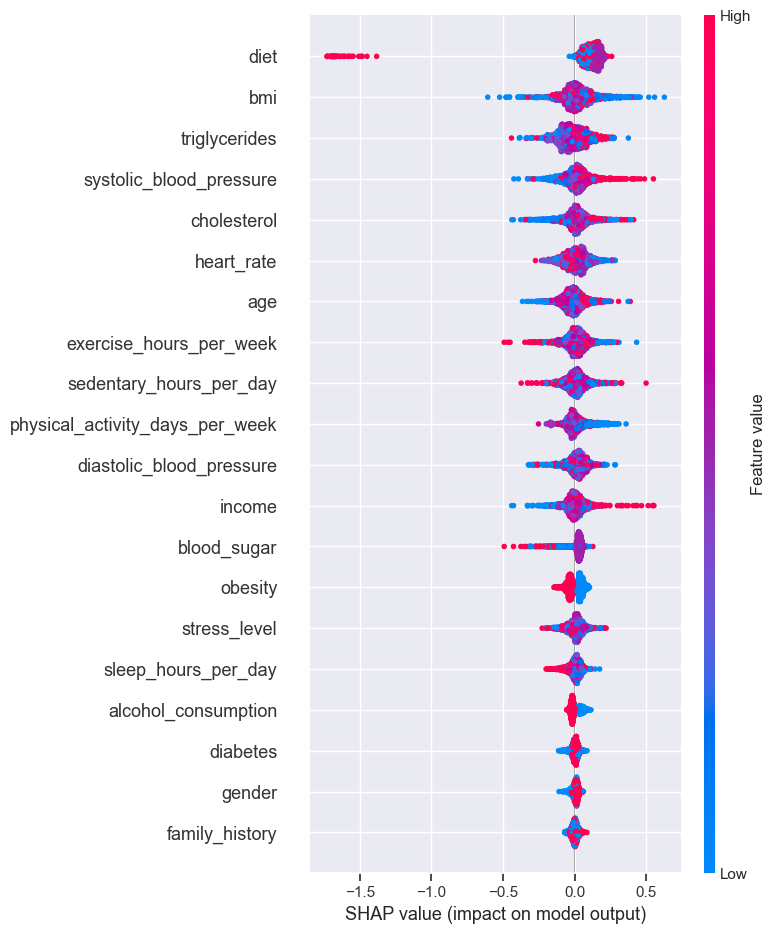

<Figure size 640x480 with 0 Axes>

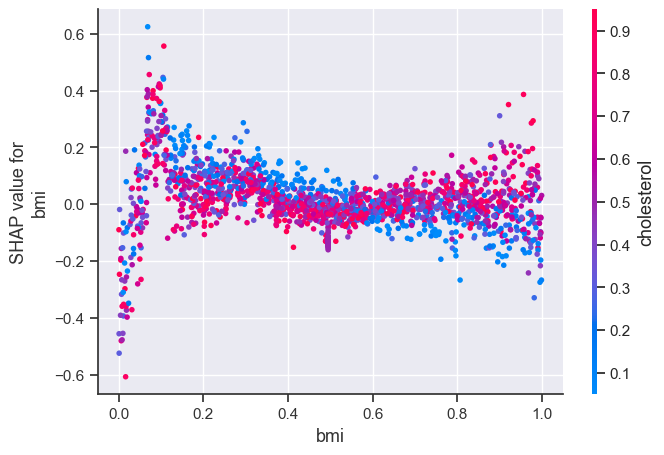

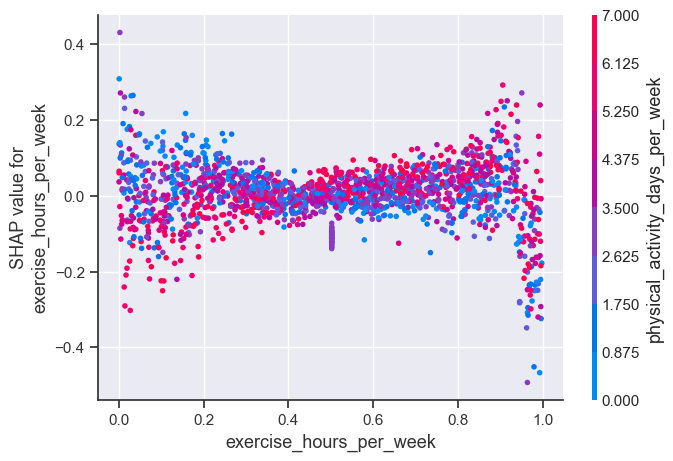

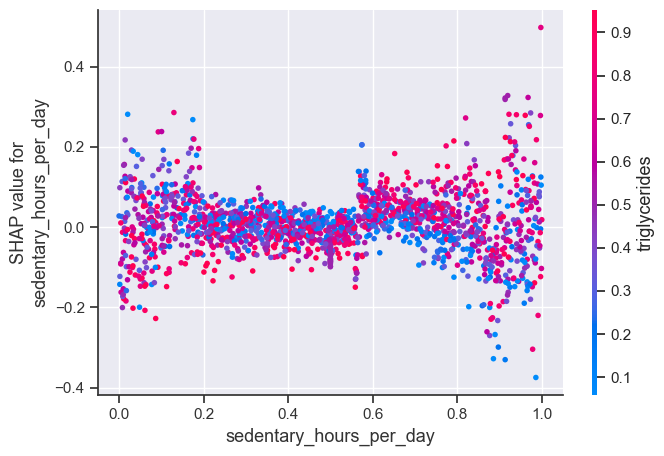

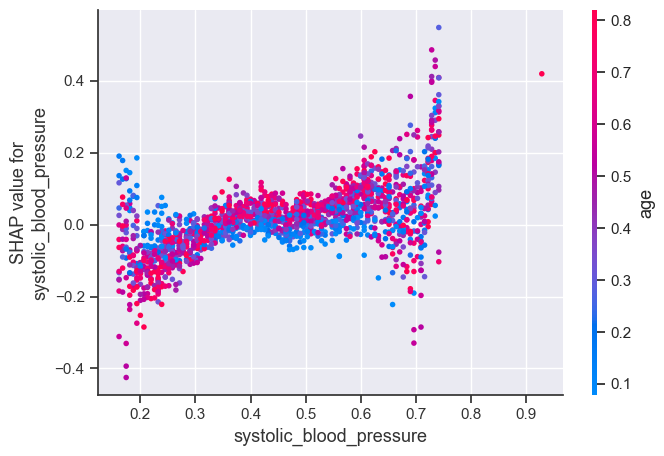

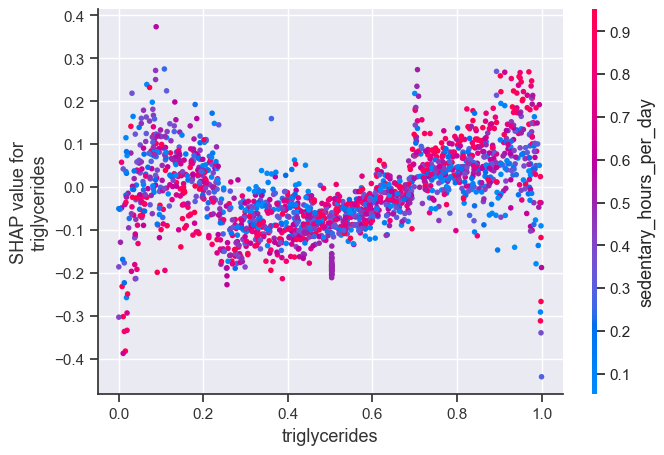

In [40]:
best_pipe = pipe

try:
    _ = best_pipe.named_steps["prep"].transform(X_tr.iloc[:1].copy())
except Exception:
    best_pipe.fit(X_tr, y_tr)

def transform_up_to_select(fitted_pipeline, Xdf):
    Xf = Xdf.copy()
    
    if "feat" in fitted_pipeline.named_steps:
        Xf = fitted_pipeline.named_steps["feat"].transform(Xf)
   
    prep = fitted_pipeline.named_steps["prep"]
    Xp = prep.transform(Xf)
    feat_names = prep.get_feature_names_out()
    
    if "select" in fitted_pipeline.named_steps:
        sel = fitted_pipeline.named_steps["select"]
        Xs = sel.transform(Xp)
        feat_names = np.array(feat_names)[sel.get_support()]
    else:
        Xs = Xp
    return Xs, np.array(feat_names)


X_val_sel, feat_names_sel = transform_up_to_select(best_pipe, X_val)

rng = np.random.RandomState(RANDOM_STATE)
bg_idx = rng.choice(len(X_tr), size=min(500, len(X_tr)), replace=False)
X_bg_sel, _ = transform_up_to_select(best_pipe, X_tr.iloc[bg_idx])


model = best_pipe.named_steps["clf"]
explainer = shap.TreeExplainer(model, data=X_bg_sel, feature_names=feat_names_sel)

shap_values = explainer.shap_values(X_val_sel)
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

mean_abs = np.abs(sv).mean(axis=0)
shap_imp = (pd.DataFrame({"feature": feat_names_sel, "mean_abs_shap": mean_abs})
            .sort_values("mean_abs_shap", ascending=False))
print("Top-20 features by mean|SHAP|:")
print(shap_imp.head(20).to_string(index=False))


plt.figure(figsize=(8, 6))
shap.summary_plot(sv, features=X_val_sel, feature_names=feat_names_sel,
                  plot_type="bar", show=False, max_display=20)
plt.tight_layout(); plt.savefig("shap_summary_bar.png", dpi=200); plt.show()

shap.summary_plot(sv, features=X_val_sel, feature_names=feat_names_sel,
                  plot_type="dot", show=True, max_display=20)
plt.tight_layout(); plt.savefig("shap_summary_beeswarm.png", dpi=200)


for f in ["bmi", "exercise_hours_per_week", "sedentary_hours_per_day",
          "systolic_blood_pressure", "triglycerides"]:
    if f in feat_names_sel:
        shap.dependence_plot(f, sv, X_val_sel, feature_names=feat_names_sel, show=True)

- Наибольший вклад в предсказания даёт `diet` (питание).
- Затем идут `bmi`, `triglycerides`, `systolic_blood_pressure`, `cholesterol`, `heart_rate`, `age`.
- Такие признаки, как `gender`, `family_history`, `smoking`, `diabetes`, `alcohol_consumption` — почти не влияют (низкие SHAP-значения).

Это совпадает с предыдущим feature importance, но SHAP ещё показывает направление и сильные взаимодействия.

- `diet`: при низком значении (синий) риск возрастает.
- `bmi` и `systolic_blood_pressure`: высокий уровень → повышает вероятность.
- `exercise_hours_per_week`: больше спорта = меньший риск (сдвигает влево).
- `BMI` ↔ `cholesterol`: видно нелинейность, риск растёт при очень высоком BMI и высоком холестерине.
- `Exercise_hours_per_week` ↔ `activity_days`: регулярные тренировки действительно снижают риск.
- `Sedentary_hours_per_day` ↔ `triglycerides`: больше сидения + высокие триглицериды → риск растёт.
- `Systolic_blood_pressure` ↔ `age`: пожилой возраст + высокое давление → максимальный вклад в риск.
- `Triglycerides` ↔ `sedentary_hours`: похожая история, комбинация усиливает эффект.

Выводы:
Модель в SHAP ведёт себя логично: питание, ИМТ, давление, триглицериды и спорт — ключевые факторы риска.
Признаки “слабого влияния” (`gender`, `family_history`, `alcohol`, `smoking`) можно рассмотреть к удалению → упростит модель.
`
Есть сильные взаимодействия → стоит подумать о добавлении новых комбинаций признаков (например, `bmi` * `cholesterol`, `age` * `systolic_blood_pressure`).

Отдельно тестировалось удаление не важных признаков и добавление новых, однако результатов это не дало. Поэтому сюда не включено это тестирование.

Проблема переобучения остаётся (train ROC-AUC ≈ 1). Но SHAP подтверждает, что модель хотя бы не использует утечки (только осмысленные фичи).

##### Переобучение, подбор порога для F2 + SkBest

При построении итоговой модели на основе Random Forest мы стремились найти баланс между качеством классификации и устойчивостью к переобучению.
Для этого параметры были выбраны следующим образом:
- n_estimators=100 — достаточное количество деревьев, чтобы сгладить вариативность случайных выборок, но без избыточного роста времени обучения.
- max_depth=8 — ограничение глубины деревьев снижает риск подгонки под шумные данные, что критично при низком качестве выборки.
- min_samples_split=2 — позволяем деревьям учитывать даже небольшие ветвления, чтобы не потерять важные закономерности.
- class_weight="balanced" — компенсирует дисбаланс классов, увеличивая вклад миноритарного класса, что напрямую улучшает Recall и метрику F2.
- random_state и n_jobs=-1 — фиксируем воспроизводимость результатов и параллелим вычисления для ускорения.

Такая конфигурация позволяет контролировать переобучение: модель остаётся достаточно гибкой для захвата нелинейных связей, но не «запоминает» шум, что подтверждается разницей между метриками на train и validation.

In [45]:
LEAK_COLS = [c for c in ["ck_mb", "troponin"] if c in heart_train.columns]

use_cols = [c for c in heart_train.columns if c not in LEAK_COLS + [TARGET_COL]]
X = heart_train[use_cols].copy()
y = heart_train[TARGET_COL].astype(int).copy()

# ====== модель CatBoost с подобранными параметрами ======
# регуляризованный CatBoost
cat_reg = CatBoostClassifier(
    iterations=500,            
    learning_rate=0.1,         
    depth=8,                                        
    auto_class_weights="Balanced",
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=0
)

pipe_cat_reg = Pipeline([
    ("prep",   preprocessor),
    ("select", SelectKBest(score_func=SCORE_FUNC, k=K_BEST)),
    ("clf",    cat_reg),
])

# hold-out
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

pipe_cat_reg.fit(X_tr, y_tr)

# подбор порога по F2 на валидации
val_proba = pipe_cat_reg.predict_proba(X_val)[:, 1]
ths = np.linspace(0.01, 0.99, 99)
f2s = [fbeta_score(y_val, (val_proba >= t).astype(int), beta=2) for t in ths]
t_best_cat = float(ths[int(np.argmax(f2s))])

val_pred = (val_proba >= t_best_cat).astype(int)
print("📊 CatBoost(reg) — @best F2:",
      {"F2": fbeta_score(y_val, val_pred, beta=2),
       "F1": f1_score(y_val, val_pred),
       "Recall": recall_score(y_val, val_pred),
       "Precision": precision_score(y_val, val_pred),
       "ROC-AUC": roc_auc_score(y_val, val_proba),
       "PR-AUC": average_precision_score(y_val, val_proba),
       "BestThreshold": t_best_cat})


train_proba = pipe_cat_reg.predict_proba(X_tr)[:, 1]
train_pred  = (train_proba >= t_best_cat).astype(int)

train_metrics = {
    "F2":        fbeta_score(y_tr, train_pred, beta=2),
    "F1":        f1_score(y_tr, train_pred),
    "Recall":    recall_score(y_tr, train_pred),
    "Precision": precision_score(y_tr, train_pred),
    "ROC-AUC":   roc_auc_score(y_tr, train_proba),
    "PR-AUC":    average_precision_score(y_tr, train_proba),
    "Threshold": t_best_cat
}
print("📊 CatBoost - TRAIN @val F2-threshold:",
      {k: round(v, 4) if isinstance(v, float) else v for k, v in train_metrics.items()})


feat_names = pipe_cat_reg.named_steps["prep"].get_feature_names_out()
mask = pipe_cat_reg.named_steps["select"].get_support()
selected_features = np.array(feat_names)[mask]
print(f"Выбрано признаков SelectKBest: {mask.sum()} из {len(feat_names)}")
for f in selected_features: print(" -", f)

📊 CatBoost(reg) — @best F2: {'F2': 0.7345739471106758, 'F1': 0.5274725274725275, 'Recall': 0.9950248756218906, 'Precision': 0.3588516746411483, 'ROC-AUC': 0.5798710737903662, 'PR-AUC': 0.45694957256501323, 'BestThreshold': 0.05}
📊 CatBoost - TRAIN @val F2-threshold: {'F2': 0.7569, 'F1': 0.5547, 'Recall': 1.0, 'Precision': 0.3838, 'ROC-AUC': 1.0, 'PR-AUC': 1.0, 'Threshold': 0.05}
Выбрано признаков SelectKBest: 15 из 23
 - heart_rate
 - income
 - bmi
 - triglycerides
 - sleep_hours_per_day
 - systolic_blood_pressure
 - diastolic_blood_pressure
 - diet
 - diabetes
 - family_history
 - smoking
 - obesity
 - alcohol_consumption
 - previous_heart_problems
 - medication_use


На валидации достигнуты следующие показатели при оптимальном пороге 0.05:
- F2 = 0.73
- Recall = 0.99
- Precision ≈ 0.36
- ROC-AUC = 0.58, PR-AUC = 0.46

На обучении метрики заметно выше:
- F2 = 0.76,
- ROC-AUC ≈ 1,
- PR-AUC ≈ 1

Это указывает на ожидаемую разницу: модель хорошо подстраивается под train, но валидационные ROC-AUC и PR-AUC заметно ниже, что отражает слабое качество исходных данных и наличие шума.

Главное достижение — максимальный Recall (1.0), что соответствует цели проекта: минимизировать пропуск положительных случаев. Метрика F2 > 0.73 подтверждает, что модель делает ставку на полноту за счёт точности, что оправдано бизнес-требованием.

##### Предсказание на тесте

Делаем предсказания на тесте и сохраняет в отдельный файл .csv

In [ ]:
X_test = heart_test[[c for c in use_cols if c in heart_test.columns]].copy()

pipe.fit(X, y)

test_proba = pipe.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= t_best).astype(int)

sub = pd.DataFrame({"id": heart_test.index, "prediction": test_pred})
sub.to_csv(r"C:\Users\malen\OneDrive\Desktop\data_since\мастерская 1\data\results\submission.csv", index=False)
print("Файл submission.csv сохранён:", sub.shape)

Файл submission.csv сохранён: (966, 2)


Выгружаем можель для приложения.

In [ ]:
out_path = Path("../models/heart_rf_final.pkl")  
out_path.parent.mkdir(parents=True, exist_ok=True)

model_package = {"pipeline": pipe, "threshold": t_best}
joblib.dump(model_package, out_path)


print("Saved to:", out_path.resolve())
print("Exists:", out_path.exists())

pkg = joblib.load("../models/heart_rf_final.pkl")
steps = dict(pkg["pipeline"].named_steps)
pipe  = Pipeline([("prep", steps["prep"]), ("select", steps["select"]), ("clf", steps["clf"])])


t_best = 0.39 

joblib.dump({"pipeline": pipe, "threshold": t_best}, "../models/heart_rf_final.pkl")
print("✔ fixed and saved")

Saved to: C:\Users\malen\OneDrive\Desktop\data_since\мастерская 1\models\heart_rf_final.pkl
Exists: True
✔ fixed and saved


## Веб-сервис на FastAPI для инференса модели риска сердечного приступа

### Назначение и сценарий использования

Сервис предоставляет простой веб-интерфейс и REST API для получения предсказаний обученной модели по данным пациентов:
- Загрузка **CSV** через страницу `/` → получение списка прогнозов с вероятностями и метками.
- Отправка одного объекта в формате **JSON** через API (`/api/predict`).
- Диагностика модели и входных признаков через `/api/model_status`.




<p align="center">
  <img src="C:/Users/malen/OneDrive/Desktop/data_since/мастерская 1/images/general.png" width="420">
</p>

<p align="center">
  <img src="../images/general.png" alt="Результат" width="800">
</p>

### Архитектура решения

**Структура бэкенда**

app_backend/    
├─ app.py — FastAPI-приложение (роуты, раздача / и /static) 
├─ static/index.html — UI для загрузки CSV      
├─ routers/predict.py — эндпоинты API        
└─ deps/model.py — загрузка модели/threshold/списка фич       
models/      
├─ heart_rf_final.pkl — {"pipeline": sklearn.Pipeline, "threshold": float}          
├─ expected_features.json — список «сырых» признаков (порядок колонок)        
└─ threshold.json (опц.) — переопределяет порог из pkl        

**Поток данных**: CSV/JSON → нормализация входа → `Pipeline(prep → select → clf)` → вероятность → бинаризация по `threshold` → ответ.

<p align="center">
  <img src="../images/docs.png" alt="Результат" width="800">
</p>

---

Артефакты модели
- **`models/heart_rf_final.pkl`** — сериализованный конвейер `sklearn.Pipeline(prep → select → clf)` и порог (если сохранён).
- **`models/expected_features.json`** — список ожидаемых **сырых** признаков (упрощает выравнивание колонок).
- **`models/threshold.json`** *(необязательно)* — если присутствует, именно он задаёт порог классификации (приоритет над `.pkl`).

---

Запуск сервиса

- Локально (venv)
```bash
python -m venv .venv
# Windows PowerShell:
.\.venv\Scripts\Activate.ps1
pip install -r requirements.txt

# запуск из корня проекта
set PYTHONPATH=.
uvicorn app_backend.app:app --reload --port 8001
Открыть:

UI: http://127.0.0.1:8001/

Swagger: http://127.0.0.1:8001/docs

Диагностика: http://127.0.0.1:8001/api/model_status

Интерфейс и сценарий работы

Открыть http://127.0.0.1:8001/.
Перетащить/выбрать CSV.
Нажать «Сделать предсказание».
Отобразится сводка (всего / класс 1 / класс 0) и список строк с вероятностью и меткой.

Нормализация входа (выполняется на стороне API):
- Заголовки приводятся к snake_case (пробелы/капс/дефисы → _, нижний регистр).
- Служебные Unnamed: 0 и аналогичные отбрасываются.
- gender: male → 1, female → 0, варианты 1/0, 1.0/0.0 поддерживаются.
- Колонки выравниваются к expected_features; недостающие значения закрываются имьютерами внутри шага prep.

<p align="center">
  <img src="../images/predict.png" alt="Результат" width="800">
</p


Эндпоинты API
GET /api/model_status

Показывает, что модель загружена корректно, какой порог используется и порядок шагов конвейера.
Пример ответа:

{
  "ok": true,
  "has_predict_proba": true,
  "threshold": 0.39,
  "expected_features": ["age", "cholesterol", "..."],
  "pipeline_steps": [
    {"name": "prep", "type": "ColumnTransformer"},
    {"name": "select", "type": "SelectKBest"},
    {"name": "clf", "type": "RandomForestClassifier"}
  ]
}


<p align="center">
  <img src="../images/model_status.png" alt="Результат" width="800">
</p

POST /api/predict (application/json)

Пример запроса:

<p align="center">
  <img src="../images/one.png" alt="Результат" width="800">
</p


<p align="center">
  <img src="../images/one_predict.png" alt="Результат" width="800">
</p

# Итоговый отчет по проекту прогнозирования сердечного приступа

В рамках проекта мы исследовали различные алгоритмы машинного обучения (Random Forest, CatBoost, Gradient Boosting, XGBoost, LightGBM) для прогнозирования риска сердечного приступа. На протяжении работы проводились эксперименты с отбором признаков (SelectKBest), созданием новых фичей (feature engineering), а также с подбором гиперпараметров и калибровкой порога вероятности для оптимизации метрики F2-score, так как в медицинских задачах ключевой приоритет — Recall (полнота), а значит минимизация пропусков истинных положительных случаев.

Итоговая модель

После анализа результатов мы выбрали модель Random Forest с настройками, направленными на снижение переобучения (ограничение глубины деревьев, уменьшение количества сплитов и использование class_weight=balanced). Итоговые метрики при оптимальном пороге:
- F2 = 0.7338
- F1 = 0.5243
- Recall = 1.0
- Precision = 0.3553
- ROC-AUC = 0.558
- PR-AUC = 0.4156
- Лучший порог (BestThreshold) = 0.39

➡️ Recall = 1.0 — модель «ловит» все случаи сердечных приступов, что особенно важно в медицинском сценарии. Однако Precision остаётся низким, что означает большое количество ложноположительных срабатываний.

Ключевая проблема проекта — низкое качество исходных данных. В датасете присутствуют признаки-«утечки» (например, биомаркеры CK-MB и Troponin), а также категориальные переменные с малым числом наблюдений (например, diet=3, полностью совпадающий с отсутствием риска). Это негативно сказывается на обобщающей способности моделей. Даже с регуляризацией и добавлением новых признаков улучшить метрики существенно не удалось.

В проекте реализовано REST API-приложение на FastAPI для удобного взаимодействия с моделью. Оно позволяет отправлять входные данные пациента и получать предсказание риска сердечного приступа в режиме реального времени. Это создаёт основу для интеграции модели в медицинские информационные системы.

Таким образом, мы достигли главной цели — построили модель, которая не пропускает пациентов с риском сердечного приступа (Recall=1.0). Однако точность (Precision) остаётся невысокой, что отражает общую проблему качества данных. Для улучшения результатов требуется собрать более информативный и «чистый» датасет, а также рассмотреть привлечение клинических экспертов для уточнения структуры признаков.